In [ ]:
# env info
#!conda info && nvcc -V && python -c "import torch, torchvision; print('PyTorch Version:', torch.__version__); print('Torchvision Version:', torchvision.__version__)"

In [1]:
import os
import torch
from torch import nn
from torch.nn import init
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchinfo import summary
from adder.adder import Adder2D, Adder2DFunction
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import scipy.stats as stats
import math
import warnings
import collections
import LARC
import LAMB

warnings.filterwarnings("ignore")
if torch.backends.cudnn.is_available():  # speed up cnn
    torch.backends.cudnn.enabled = True
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ["CUDA_DEVICES_ORDER"]="PCI_BUS_IS"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using /root/.cache/torch_extensions/py38_cu114 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py38_cu114/adder_cuda/build.ninja...
Building extension module adder_cuda...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
ninja: no work to do.
Loading extension module adder_cuda...


In [2]:
args = {}
kwargs = {}
args['clean'] = False
args['batch_size'] = 1000
args['epochs'] = 63  # 7, 15, 31, 63, 127, 255 for CosineAnnealingWarmRestarts
args['lr'] = 0.1  # Learning rate is how fast it will decend.
args['optimizer'] = 'SGD'  # 'SGD', 'SGD_nesterov', 'AdamW', 'AdamW_amsgrad', 'Adadelta', 'RMSprop', 'LAMB'
# 'Const', 'Step', 'Cos', 'CosAn', 'OneCycle'
args['scheduler'] = 'Const'
args['log_interval'] = 10
args['cuda'] = True
args['seed'] = 42  # random seed
args['timer'] = True
args['cam'] = False
args['verb'] = True
args['save'] = [1, args['epochs']//3, args['epochs']*2//3, args['epochs']] if args['epochs'] > 8 \
                else [1, args['epochs']//2, args['epochs']] # save model at 1, 1/3 epochs, 2/3 epochs, final epochs
args['bins'] = 200

print(args)

torch.manual_seed(args['seed'])

{'clean': False, 'batch_size': 1000, 'epochs': 63, 'lr': 0.1, 'optimizer': 'SGD', 'scheduler': 'Const', 'log_interval': 10, 'cuda': True, 'seed': 42, 'timer': True, 'cam': False, 'verb': True, 'save': [1, 21, 42, 63], 'bins': 200}


In [4]:
if args['clean']:
    import shutil
    #dir_list = ["./checkpoints", "./images"]
    dir_list = ["./checkpoints"]
    for d in dir_list:
        if os.path.exists(d):
            shutil.rmtree(d)
        if not os.path.exists(d):
            os.makedirs(d)

In [5]:
if args['cam']:
    import cv2
    from pytorch_grad_cam import GradCAM
    from pytorch_grad_cam import GuidedBackpropReLUModel
    from pytorch_grad_cam.utils.image import show_cam_on_image, deprocess_image, preprocess_image
    from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

In [3]:
# define macro
LOSS_SCALE = 1000  # amplify average loss for significant ploting
INIT_LR = 0.001  # initial learning rate
#BOUND = 4
TC = 0.02 # 
VV = 10

NUM_CLASSES = 10 # cifiar 10
BIAS = False

# define global var
df_dict = {}

In [4]:
class LayerNorm(nn.Module):
    def __init__(self, batch_size=1, eps: float = 1e-5, affine: bool = True):
        
        super().__init__()
        
        self.batch_size = batch_size
        self.eps = eps
        self.affine = affine
        self.test = test
        
        if self.affine:
            self.scale = nn.Parameter(torch.ones(self.batch_size))
            self.shift = nn.Parameter(torch.zeros(self.batch_size))
        
    def forward(self, x: torch.Tensor):
        N, C, *kernel_shape = x.shape
        #assert N == self.batch_size
        x = x.view(N, -1)
        var, mean = torch.var_mean(x, dim=1, keepdim=True)
        if self.affine:
            x = self.scale.view(self.batch_size, -1) * (x - mean) / (torch.sqrt(var + self.eps)) + self.shift.view(self.batch_size, -1)
        else:
            x = (x - mean) / (torch.sqrt(var + self.eps))
            
        return x.view(N, C, *kernel_shape)


class conv2d(nn.Conv2d): # with Weight Standardization

    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=False, aws=True, eps=1e-5):
        super(conv2d, self).__init__(in_channels, out_channels, kernel_size, stride, 
                                     padding, dilation, groups, bias)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.aws = aws
        self.eps = eps
        if self.aws:
            self.scale = nn.Parameter(torch.ones(self.out_channels))
            self.shift = nn.Parameter(torch.zeros(self.out_channels))

    def forward(self, x):
        
        weight = self.weight

        c_out, c_in, *kernel_shape = weight.shape
        assert c_in == self.in_channels
        assert c_out == self.out_channels
        weight = weight.view(c_out, -1)
        var, mean = torch.var_mean(weight, dim=1, keepdim=True)
        
        if self.aws:
            weight = self.scale.view(c_out, -1) * (weight - mean) / (torch.sqrt(var + self.eps)) + self.shift.view(c_out, -1)
        else:
            weight = (weight - mean) / (torch.sqrt(var + self.eps))
            
        weight = weight.view(c_out, c_in, *kernel_shape)
                
        return F.conv2d(x, weight, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)

class adder2d(Adder2D): # with Weight Standardization

    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, bias=False, aws=True, eps=1e-5):
        super(adder2d, self).__init__(in_channels, out_channels, kernel_size, stride,
                                      padding, bias)
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.aws = aws
        self.eps = eps
        if self.aws:
            self.scale = nn.Parameter(torch.ones(self.out_channels))
            self.shift = nn.Parameter(torch.zeros(self.out_channels))

    def forward(self, x):
        
        weight = self.adder

        c_out, c_in, *kernel_shape = weight.shape
        assert c_in == self.in_channels
        assert c_out == self.out_channels
        weight = weight.view(c_out, -1)
        var, mean = torch.var_mean(weight, dim=1, keepdim=True)

        if self.aws:
            weight = self.scale.view(c_out, -1) * (weight - mean) / (torch.sqrt(var + self.eps)) + self.shift.view(c_out, -1)
        else:
            weight = (weight - mean) / (torch.sqrt(var + self.eps))
        
        weight = weight.view(c_out, c_in, *kernel_shape)

        return Adder2DFunction.apply(x, weight, self.kernel_size, self.stride,
                                    self.padding, self.eta, self.quantize, self.weight_bits, self.quantize_v)

In [5]:
# data loader
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

data_train = datasets.CIFAR10('./data', transform=transform_train, download=True)
data_test = datasets.CIFAR10('./data', train=False, transform=transform_test)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=args['batch_size'], shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=args['batch_size'], num_workers=0)

Files already downloaded and verified


In [6]:
def init_laplace(tensor):
    if 0 in tensor.shape:
        warnings.warn("Initializing zero-element tensors is a no-op")
        return tensor
    fan = init._calculate_correct_fan(tensor, 'fan_in')
    gain = VV * init.calculate_gain('relu', 0)
    std = gain / math.sqrt(2 * fan)
    #print(f'fan:{fan:.2f}\tgain:{gain:.2f}\tstd:{std:.2f}')
    gen = torch.distributions.laplace.Laplace(torch.tensor([0.0]), torch.tensor([std]))
    #gen = torch.distributions.laplace.Laplace(torch.tensor([0.0]), torch.tensor([1/math.sqrt(2)]))
    return nn.Parameter(gen.rsample(tensor.size()).squeeze(-1))


def init_uniform(tensor):
    if 0 in tensor.shape:
        warnings.warn("Initializing zero-element tensors is a no-op")
        return tensor
    fan = init._calculate_correct_fan(tensor, 'fan_in')
    gain = VV * init.calculate_gain('relu', 0)
    std = gain / math.sqrt(fan)
    bound = math.sqrt(5.0) * std
    #print(f'fan:{fan:.2f}\tgain:{gain:.2f}\tstd:{std:.2f}\tbound:{bound:2f}')
    return tensor.uniform_(-bound, bound)

def init_norm(tensor):
    if 0 in tensor.shape:
        warnings.warn("Initializing zero-element tensors is a no-op")
        return tensor
    fan = init._calculate_correct_fan(tensor, 'fan_in')
    gain = VV * init.calculate_gain('relu', 0)
    std = gain / math.sqrt(fan)
    return tensor.normal_(0, std)


def initParams(model, init_mode='None'):
    global is_adder
    
    assert init_mode in ['None', 'uniform', 'norm', 'laplace'], f"init_mode is {init_mode}"
        
    with torch.no_grad():
        for i, m in enumerate(model.modules()):
            if isinstance(m, nn.Conv2d):
                is_adder.append(False)
                # default init:
                # init.kaiming_uniform_(self.weight, a=math.sqrt(5))
                if init_mode is 'norm':
                    init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                else:
                    init.kaiming_uniform_(m.weight, a=0)
            elif isinstance(m, nn.BatchNorm2d):
                # default init:
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                # use default init:
                init.kaiming_uniform_(self.weight, a=0)
            elif isinstance(m, Adder2D):
                is_adder.append(True)
                if init_mode is 'laplace':
                    m.adder = init_laplace(m.adder)
                elif init_mode is 'uniform':
                    #m.adder.uniform_(-BOUND, BOUND)
                    init_uniform(m.adder)
                elif init_mode is 'norm':
                    #m.adder = nn.Parameter(init.normal_(m.adder))
                    init_norm(m.adder)
                else:
                    #init.kaiming_uniform_(m.adder, a=0)
                    m.adder = nn.Parameter(init.normal_(m.adder))
                    
    checkpoint = {'model': model.state_dict()}
    torch.save(checkpoint, './checkpoints/' + str(type(model).__name__) + '_0' + '.pth')
    
    
def get_stat(model, aws=False):
    w_norm = []
    g_norm = []
    w_std = []
    g_std = []
    scale = []
    shift = []
    #for i, p in enumerate(optim.param_groups[0]['params']):
    #    if i in [0, 3, 6, 9, 12]: # conv1 : conv5
    #        w_norm.append(torch.norm(p.data).cpu())
    #        g_norm.append(torch.norm(p.grad.data).cpu())
    #        w_std.append(torch.std(p.data).cpu())
    #        g_std.append(torch.std(p.grad.data).cpu())
                
    for n, p in model.named_parameters():
        if 'conv' in n and p.dim() == 4:
            #print('----- layer {} param size {} -----'.format(n, p.size()))
            w_norm.append(torch.norm(p.data).cpu())
            g_norm.append(torch.norm(p.grad.data).cpu())
            w_std.append(torch.std(p.data).cpu())
            g_std.append(torch.std(p.grad.data).cpu())            
        if 'scale' in n and 'conv' in n and aws:
            scale.append(torch.mean(p.data).cpu())
        if 'shift' in n and 'conv' in n and aws:
            shift.append(torch.mean(p.data).cpu())
            
    if aws:
        return w_norm, g_norm, w_std, g_std, scale, shift
    else:
        return w_norm, g_norm, w_std, g_std
    
def select_optimizer_scheduler(opt='SGD', sch='Const', aws=False):
    global optimizer, scheduler
    
    lr = INIT_LR if sch is 'OneCycleLR' else args['lr']
        
    # number of iteration in each epoch
    iter_epoch = len(train_loader.dataset) // args['batch_size']


    if aws:
        tiny_params = []
        normal_params = []
        for key, value in dict(model.named_parameters()).items():
            if value.requires_grad:
                if 'conv' in key and ('scale' in key or 'shift' in key):
                    tiny_params.append(value)
                    print('tiny params', key)
                else:
                    normal_params.append(value)
                    print('normal params', key)
        params = [{'params': normal_params, 'lr': lr, 'weight_decay': 5e-4},
                  {'params': tiny_params, 'lr': 0.01 * lr, 'weight_decay': 5e-4}]
    else:
        params = model.parameters()
    
    if opt is 'SGD':
        optimizer = optim.SGD(params, lr=lr, momentum=0.5, weight_decay=5e-5, nesterov=False)
    elif opt is 'SGD_nesterov':
        optimizer = optim.SGD(params, lr=lr, momentum=0.5, weight_decay=5e-5, nesterov=True)
    elif opt is 'AdamW':
        optimizer = optim.AdamW(params, lr=lr, betas=(0.9, 0.999), eps=1e-8, weight_decay=5e-4, amsgrad=False)
    elif opt is 'AdamW_amsgrad':
        optimizer = optim.AdamW(params, lr=lr, betas=(0.9, 0.999), eps=1e-8, weight_decay=5e-4, amsgrad=True)
    elif opt is 'Adadelta':
        optimizer = optim.Adadelta(params, lr=lr)
    elif opt is 'RMSprop':
        optimizer = optim.RMSprop(params, lr=lr, alpha=0.99, momentum=0.5, centered=True)
    elif opt is 'LAMB':
        optimizer = LAMB.Lamb(model.params, lr=lr, weight_decay=5e-4, betas=(.9, .999), adam=False)
    else:
        raise ValueError(f'Wrong Opt: {opt}.')  

        
                  
    if sch is 'Const':
        scheduler = None
    elif sch is 'Step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=iter_epoch*args['epochs']//3, gamma=0.2)  # every 1/3 epoch lr*0.1
    elif sch is 'Cos':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=iter_epoch*args['epochs'], eta_min=0.001)  # half cos
    elif sch is 'CosAn':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=iter_epoch*args['epochs']//5, eta_min=0.001),  # 5 half cos
    elif sch is 'CosAnWR':
        scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=iter_epoch*1, T_mult=2, eta_min=0.001),  # 5 half cos, epoch=7, 15, 31, 63, 127, 255
    elif sch is 'OneCycle':
        scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=args['lr'], steps_per_epoch=iter_epoch, anneal_strategy='cos', epochs=args['epochs']) # strategy: cos, linear 
    else:
        raise ValueError(f'Wrong Sch: {sch}.')  


def train(epoch, sch, timer, aws=False):
    global count, train_loss_list, iteration_list, lr_list
    global wnorm1_list, wnorm2_list, wnorm3_list, wnorm4_list, wnorm5_list, gnorm1_list, gnorm2_list, gnorm3_list, gnorm4_list, gnorm5_list
    global wstd1_list, wstd2_list, wstd3_list, wstd4_list, wstd5_list, gstd1_list, gstd2_list, gstd3_list, gstd4_list, gstd5_list
    if aws:
        global scale1_list, scale2_list, scale3_list, scale4_list, scale5_list, shift1_list, shift2_list, shift3_list, shift4_list, shift5_list
    global optimizer, criterion, scheduler
    train_loss = 0

    model.train()

    if timer:
        global time
        time = 0
        start = torch.cuda.Event(enable_timing=True)
        end = torch.cuda.Event(enable_timing=True)

    for batch_idx, (data, target) in enumerate(train_loader):
        if args['cuda']:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()

        if timer:
            start.record()
        outputs = model(data)
        if timer:
            end.record()
            torch.cuda.synchronize()
            elapsed = start.elapsed_time(end)
            time += elapsed
    
        loss = criterion(outputs, target)
        train_loss += loss.item() / float(len(data))
        loss.backward()
        optimizer.step()
        
        count += 1
        if count % args['log_interval'] == 0 or count == 1:
            accuracy = test()
            model.train()
            if count == 1:
                train_loss = train_loss * LOSS_SCALE
            else:
                train_loss = train_loss / float(args['log_interval']) * LOSS_SCALE
            train_loss_list.append(train_loss)
            iteration_list.append(count)
            lr = optimizer.param_groups[0]["lr"]
            lr_list.append(lr)
            
            if aws:
                w_norm, g_norm, w_std, g_std, scale, shift = get_stat(model, aws)
            else:  
                w_norm, g_norm, w_std, g_std = get_stat(model, aws)   
                
            wnorm1_list.append(w_norm[0])
            wnorm2_list.append(w_norm[1])
            wnorm3_list.append(w_norm[2])
            wnorm4_list.append(w_norm[3])
            wnorm5_list.append(w_norm[4])
            gnorm1_list.append(g_norm[0])
            gnorm2_list.append(g_norm[1])
            gnorm3_list.append(g_norm[2])
            gnorm4_list.append(g_norm[3])
            gnorm5_list.append(g_norm[4])
            wstd1_list.append(w_std[0])
            wstd2_list.append(w_std[1])
            wstd3_list.append(w_std[2])
            wstd4_list.append(w_std[3])
            wstd5_list.append(w_std[4])
            gstd1_list.append(g_std[0])
            gstd2_list.append(g_std[1])
            gstd3_list.append(g_std[2])
            gstd4_list.append(g_std[3])
            gstd5_list.append(g_std[4])
            
            if aws:
                scale1_list.append(scale[0])
                scale2_list.append(scale[1])
                scale3_list.append(scale[2])
                scale4_list.append(scale[3])
                scale5_list.append(scale[4])
                shift1_list.append(shift[0])
                shift2_list.append(shift[1])
                shift3_list.append(shift[2])
                shift4_list.append(shift[3])
                shift5_list.append(shift[4])

            if timer:
                if args['verb']:
                    print('Train Epoch:{} [{}/{}]\tIter:{}  \tElapsed:{:.2f}s\tLR:{:.4f}\tLoss:{:.4f}\tAccuracy:{:.2f}\tW1:{:.4f}\tW5:{:.4f}\tG1:{:.4f}\tG5:{:.4f}'.format(
                          epoch, (batch_idx+1)*len(data), len(train_loader.dataset), count,
                          time/1000, lr, train_loss, accuracy, w_norm[0], w_norm[4], g_norm[0], g_norm[4]))
                time = 0
            else:
                if args['verb']:
                    print('Train Epoch:{} [{}/{}]\tIter:{}  \tLR:{:.4f}\tLoss:{:.4f}\tAccuracy:{:.2f}\tW1:{:.4f}\tW2:{:.4f}\tG1{:.4f}\tG2{:.4f}'.format(
                          epoch, (batch_idx+1)*len(data), len(train_loader.dataset), count,
                          lr, train_loss, accuracy, w_norm[0], w_norm[4], g_norm[0], g_norm[4]))

            train_loss = train_loss / LOSS_SCALE if count is 1 else 0

        if sch is not 'Const':
            scheduler.step()
        

def test():
    global test_loss_list, accuracy_list
    global criterion
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if args['cuda']:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data, volatile=True), Variable(target)
            outputs = model(data)
            # sum up iter or epoch loss
            test_loss += criterion(outputs, target).item()
            # pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            pred = torch.max(outputs.data, 1)[1]
            correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()
    test_loss = test_loss / float(len(test_loader.dataset)) * LOSS_SCALE
    accuracy = 100 * correct.item() / float(len(test_loader.dataset))

    test_loss_list.append(test_loss)
    accuracy_list.append(accuracy)

    return accuracy


def run(model, opt='SGD', sch='Const', init_mode=None, en_larc=False, aws=False):
    '''
    model: LeNet5_BN_FCN(), LeNet5_BN_FAN()
    optim: 'SGD', 'SGD_nesterov', 'AdamW', 'AdamW_amsgrad', 'Adadelta'
    sch: 'Const', 'Step', 'Cos', 'CosAn', 'CosAnWR', 'OneCycle'
    '''
    
    if args['verb']: 
        print(f"{opt}\t{sch}") 
    
    global time, count, df_dict, is_adder
    global train_loss_list, test_loss_list, accuracy_list, iteration_list, lr_list
    global wnorm1_list, wnorm2_list, wnorm3_list, wnorm4_list, wnorm5_list, gnorm1_list, gnorm2_list, gnorm3_list, gnorm4_list, gnorm5_list
    global wstd1_list, wstd2_list, wstd3_list, wstd4_list, wstd5_list, gstd1_list, gstd2_list, gstd3_list, gstd4_list, gstd5_list
    if aws:
        global scale1_list, scale2_list, scale3_list, scale4_list, scale5_list, shift1_list, shift2_list, shift3_list, shift4_list, shift5_list
    global optimizer, criterion, scheduler

    is_adder = []
    # model parameters initialization
    initParams(model, init_mode)
    
    select_optimizer_scheduler(opt, sch, aws)
    if en_larc:
        optimizer = LARC.LARC(optimizer=optimizer, trust_coefficient=TC) # trust_coefficient hyperparam
    criterion = nn.CrossEntropyLoss()

    if args['cuda']:
        model.cuda()
        criterion.cuda()

    time = 0
    count = 0
    train_loss_list = []
    test_loss_list = []
    accuracy_list = []
    iteration_list = []
    lr_list = []
    wnorm1_list = []
    wnorm2_list = []
    wnorm3_list = []
    wnorm4_list = []
    wnorm5_list = []
    gnorm1_list = []
    gnorm2_list = []
    gnorm3_list = []
    gnorm4_list = []
    gnorm5_list = []
    wstd1_list = []
    wstd2_list = []
    wstd3_list = []
    wstd4_list = []
    wstd5_list = []
    gstd1_list = []
    gstd2_list = []
    gstd3_list = []
    gstd4_list = []
    gstd5_list = []
    
    if aws:
        scale1_list = []
        scale2_list = []
        scale3_list = []
        scale4_list = []
        scale5_list = []
        shift1_list = []
        shift2_list = []
        shift3_list = []
        shift4_list = []
        shift5_list = []
    
    
    for name, param in model.named_parameters():
        print(name, param.requires_grad, param.data.size())
    
    #aws_flag = 0
    
    for epoch in range(1, args['epochs']+1):
        train(epoch, sch, args['timer'], aws)
        if epoch in args['save']:
            checkpoint = {
                'model': model.state_dict(),
                #'optimizer': optimizer.state_dict(),
            }
            path = './checkpoints/' + str(type(model).__name__) + '_' + str(epoch) + '.pth'
            os.remove(path) if os.path.exists(path) else None
            torch.save(checkpoint, path)
        #if aws and aws_flag == 0:
        #    if optimizer.param_groups[0]['lr'] < 0.01:
        #        for name, param in model.named_parameters():
        #            if ('scale' in name or 'shift' in name) and 'conv' in name: 
        #                param.requires_grad =True
        #                print('{}.reguires_grad = True'.format(name))
        #        aws_flag = 1
                

    if aws:
        list_all = [iteration_list, train_loss_list,
                    test_loss_list, accuracy_list, lr_list, 
                    wnorm1_list, wnorm2_list, wnorm3_list, wnorm4_list, wnorm5_list, gnorm1_list, gnorm2_list, gnorm3_list, gnorm4_list, gnorm5_list,
                    wstd1_list, wstd2_list, wstd3_list, wstd4_list, wstd5_list, gstd1_list, gstd2_list, gstd3_list, gstd4_list, gstd5_list,
                    scale1_list, scale2_list, scale3_list, scale4_list, scale5_list, shift1_list, shift2_list, shift3_list, shift4_list, shift5_list]
    else:
        list_all = [iteration_list, train_loss_list,
                    test_loss_list, accuracy_list, lr_list, 
                    wnorm1_list, wnorm2_list, wnorm3_list, wnorm4_list, wnorm5_list, gnorm1_list, gnorm2_list, gnorm3_list, gnorm4_list, gnorm5_list,
                    wstd1_list, wstd2_list, wstd3_list, wstd4_list, wstd5_list, gstd1_list, gstd2_list, gstd3_list, gstd4_list, gstd5_list]
        
    df = pd.DataFrame(list_all).transpose()
    
    if aws:
        df.columns = ['iter', 'train_loss', 'test_loss', 'accuracy', 'lr', 
                      'wnorm1', 'wnorm2', 'wnorm3', 'wnorm4', 'wnorm5', 'gnorm1', 'gnorm2', 'gnorm3', 'gnorm4', 'gnorm5',
                      'wstd1', 'wstd2', 'wstd3', 'wstd4', 'wstd5', 'gstd1', 'gstd2', 'gstd3', 'gstd4', 'gstd5',
                      'scale1', 'scale2', 'scale3', 'scale4', 'scale5', 'shift1', 'shift2', 'shift3', 'shift4', 'shift5']
    else:
        df.columns = ['iter', 'train_loss', 'test_loss', 'accuracy', 'lr', 
                      'wnorm1', 'wnorm2', 'wnorm3', 'wnorm4', 'wnorm5', 'gnorm1', 'gnorm2', 'gnorm3', 'gnorm4', 'gnorm5',
                      'wstd1', 'wstd2', 'wstd3', 'wstd4', 'wstd5', 'gstd1', 'gstd2', 'gstd3', 'gstd4', 'gstd5']
        
    name = type(model).__name__
    #str_larc = 'enlarc' if en_larc else 'nolarc'
    #path = f'./results/{name}_{opt}_{sch}_{init_mode}_{str_larc}_{epoch}.csv'
    str_aws = 'aws' if aws else 'noaws'
    path = f'./results/{name}_{opt}_{sch}_{init_mode}_{str_aws}_{epoch}.csv'
    df.to_csv(path, index=False)
    df_dict[str(name)] = df


def plot_train_test(aws=False):
    global train_loss_list, test_loss_list, accuracy_list, iteration_list, lr_list
    global wnorm1_list, wnorm2_list, wnorm3_list, wnorm4_list, wnorm5_list, gnorm1_list, gnorm2_list, gnorm3_list, gnorm4_list, gnorm5_list
    global wstd1_list, wstd2_list, wstd3_list, wstd4_list, wstd5_list, gstd1_list, gstd2_list, gstd3_list, gstd4_list, gstd5_list
    if aws:
        global scale1_list, scale2_list, scale3_list, scale4_list, scale5_list, shift1_list, shift2_list, shift3_list, shift4_list, shift5_list
    
        fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(nrows=4, ncols=2,
                                                                     sharey=False, sharex=False, figsize=(14, 18))
    else:
        fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2,
                                                                 sharey=False, sharex=False, figsize=(14, 14))

    # visualization loss
    ax1.plot(iteration_list, train_loss_list, label=f'Train Loss: {train_loss_list[-1]:.4f}')
    ax1.plot(iteration_list, test_loss_list, label=f'Test Loss: {test_loss_list[-1]:.4f}')
    ax1.set_xlabel("Number of iteration")
    ax1.set_ylabel("Loss")
    ax1.set_title("Loss")
    ax1.legend(loc='upper right')

    ax2.plot(iteration_list, accuracy_list, label=f'Accuracy: {max(accuracy_list)}', color='red')
    ax2_ex = ax2.twinx()
    ax2_ex.plot(iteration_list, lr_list, label='Learning Rate', color='blue', alpha=0.3)
    ax2_ex.set_ylabel("Learning Rate")
    ax2.set_xlabel("Number of iteration")
    ax2.set_ylabel("Accuracy")
    ax2.set_title("Accuracy and Learning Rate")
    ax2.legend(loc='lower right')

    ax3.plot(iteration_list, gnorm1_list, label='Conv1 G')
    ax3.plot(iteration_list, gnorm2_list, label='Conv2 G')
    ax3.plot(iteration_list, gnorm3_list, label='Conv3 G')
    ax3.plot(iteration_list, gnorm4_list, label='Conv4 G')
    ax3.plot(iteration_list, gnorm5_list, label='Conv5 G')
    ax3.set_xlabel("Number of iteration")
    ax3.set_ylabel("Grads Norm")
    ax3.set_title("Gradients Norm of Layers")
    ax3.legend(loc='best')

    ax4.plot(iteration_list, wnorm1_list, label='Conv1 W')
    ax4.plot(iteration_list, wnorm2_list, label='Conv2 W')
    ax4.plot(iteration_list, wnorm3_list, label='Conv3 W')
    ax4.plot(iteration_list, wnorm4_list, label='Conv4 W')
    ax4.plot(iteration_list, wnorm5_list, label='Conv5 W')
    ax4.set_xlabel("Number of iteration")
    ax4.set_ylabel("Weights Norm")
    ax4.set_title("Weights Norm of Layers")
    ax4.legend(loc='best')
    
    ax5.plot(iteration_list, gstd1_list, label='Conv1 G')
    ax5.plot(iteration_list, gstd2_list, label='Conv2 G')
    ax5.plot(iteration_list, gstd3_list, label='Conv3 G')
    ax5.plot(iteration_list, gstd4_list, label='Conv4 G')
    ax5.plot(iteration_list, gstd5_list, label='Conv5 G')
    ax5.set_xlabel("Number of iteration")
    ax5.set_ylabel("Grads STD")
    ax5.set_title("Gradients STD of Layers")
    ax5.legend(loc='best')
    
    ax6.plot(iteration_list, wstd1_list, label='Conv1 W')
    ax6.plot(iteration_list, wstd2_list, label='Conv2 W')
    ax6.plot(iteration_list, wstd3_list, label='Conv3 W')
    ax6.plot(iteration_list, wstd4_list, label='Conv4 W')
    ax6.plot(iteration_list, wstd5_list, label='Conv5 W')
    ax6.set_xlabel("Number of iteration")
    ax6.set_ylabel("Weights STD")
    ax6.set_title("Weights STD of Layers")
    ax6.legend(loc='best')

    if aws:
        ax7.plot(iteration_list, scale1_list, label='scale1')
        ax7.plot(iteration_list, scale2_list, label='scale2')
        ax7.plot(iteration_list, scale3_list, label='scale3')
        ax7.plot(iteration_list, scale4_list, label='scale4')
        ax7.plot(iteration_list, scale5_list, label='scale5')
        ax7.set_xlabel("Number of iteration")
        ax7.set_ylabel("Scale")
        ax7.set_title("AWS Scale of Layers")
        ax7.legend(loc='best')
        
        ax8.plot(iteration_list, shift1_list, label='shift1')
        ax8.plot(iteration_list, shift2_list, label='shift2')
        ax8.plot(iteration_list, shift3_list, label='shift3')
        ax8.plot(iteration_list, shift4_list, label='shift4')
        ax8.plot(iteration_list, shift5_list, label='shift5')
        ax8.set_xlabel("Number of iteration")
        ax8.set_ylabel("Shift")
        ax8.set_title("AWS Shift of Layers")
        ax8.legend(loc='best')
    
    fig.tight_layout()
    plt.show()


def plot_multi(df_dict, opt='SGD', sch='ConstLR'):
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3,
                                        sharey=False, sharex=True, figsize=(22, 7))

    for key in df_dict.keys():
        ax1.plot(df_dict[key].iter, df_dict[key].train_loss,
                 label=f'{key}: {df_dict[key].train_loss.iloc[-1]:.4f}')
        ax2.plot(df_dict[key].iter, df_dict[key].test_loss,
                 label=f'{key}: {df_dict[key].test_loss.iloc[-1]:.4f}')
        ax3.plot(df_dict[key].iter, df_dict[key].accuracy,
                 label=f'{key}: {max(df_dict[key].accuracy)}')

    key = list(df_dict.keys())[0]
    ax1lr = ax1.twinx()
    ax1lr.plot(df_dict[key].iter, df_dict[key].lr, label='LR', alpha=0.2)
    ax1.set_xlabel("Number of iteration")
    ax1.set_ylabel("Train Loss")
    ax1.set_title(f"Train Loss with {opt} & {sch}")
    ax1.legend(loc='upper right')

    ax2lr = ax2.twinx()
    ax2lr.plot(df_dict[key].iter, df_dict[key].lr, label='LR', alpha=0.2)
    ax2.set_xlabel("Number of iteration")
    ax2.set_ylabel("Test Loss")
    ax2.set_title(f"Test Loss with {opt} & {sch}")
    ax2.legend(loc='upper right')

    ax3lr = ax3.twinx()
    ax3lr.plot(df_dict[key].iter, df_dict[key].lr, label='LR', alpha=0.2)
    ax3.set_xlabel("Number of iteration")
    ax3.set_ylabel("Accuracy")
    ax3.set_title(f"Accuracy with {opt} & {sch}")
    ax3.legend(loc='lower right')

    fig.tight_layout()
    plt.show()

def plot_hist(model):
    global is_adder
    #print('is adder layer: ', ' '.join(str(i)+'.'+str(x) for i, x in enumerate(is_adder)))
    
    name = str(type(model).__name__)
    checkpoints = [name + '_' + str(x) + '.pth' for x in args['save']]
    checkpoints.insert(0, name + '_0' + '.pth')
    
    col_num = 5 if args['epochs'] > 8 else 4
    fig_size = 4
    figs_size = fig_size * col_num
    
    fig, ax = plt.subplots(1,col_num, figsize=(figs_size,fig_size))
    fig.suptitle('Conv Layers Weight Distribution')
    ax = ax.ravel()
    
    for i, axi in enumerate(ax):
        checkpoint = checkpoints[i]
        checkpoint = torch.load('./checkpoints/' + checkpoint)
        model.load_state_dict(checkpoint['model'])
        
        conv_weight = []
        adder_weight = []
        k = 0
        for j, (name, param) in enumerate(model.named_parameters()):
            if param.dim() == 4:
                if is_adder[k]:
                    #print(f'{k} {name} is adder layer')
                    adder_weight.append(param.cpu().data.numpy().flatten())
                else:
                    #print(f'{k} {name} is conv layer')
                    conv_weight.append(param.cpu().data.numpy().flatten())
                k += 1
                
        epoch = 0 if i == 0 else args['save'][i-1]
        axi_ex = axi.twinx()
        
        if len(adder_weight) != 0:
            adder_weight = np.concatenate(adder_weight)
            adder_norm = np.linalg.norm(adder_weight)
            adder_mean = np.mean(adder_weight)
            adder_std = np.std(adder_weight)
            adder_max = np.max(adder_weight)
            adder_min = np.min(adder_weight)
            axi.hist(adder_weight, bins=args['bins'], alpha=0.5, label='Adder')
            a = np.linspace(adder_mean-4*adder_std, adder_mean+4*adder_std, args['bins'])
            axi_ex.plot(a, stats.laplace.pdf(a, adder_mean, adder_std), alpha=0.3, color='red')
            print(f'Weight \tepoch:{epoch} \tadder norm:{adder_norm:.6f}\tadder std:{adder_std:.6f}\tadder max:{adder_max:.6f}\tadder min:{adder_min:.6f}')
        if len(conv_weight) != 0:
            conv_weight = np.concatenate(conv_weight)
            conv_norm = np.linalg.norm(conv_weight)
            conv_mean = np.mean(conv_weight)
            conv_std = np.std(conv_weight)
            conv_max = np.max(conv_weight)
            conv_min = np.min(conv_weight)
            axi.hist(conv_weight, bins=args['bins'], alpha=0.5, label='Conv')
            c = np.linspace(conv_mean-4*conv_std, conv_mean+4*conv_std, args['bins'])
            axi_ex.plot(c, stats.norm.pdf(c, conv_mean, conv_std), alpha=0.3, color='blue')
            print(f'Weight \tepoch:{epoch} \tconv norm:{conv_norm:.6f} \tconv std:{conv_std:.6f} \tconv max:{conv_max:.6f} \tconv  min:{conv_min:.6f}')
        
        axi.legend(loc='best')
        axi.set_title(f'epoch{epoch}')
    
    plt.tight_layout()
    plt.show()
    

In [10]:
class AlexNet_BN_FCN(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(AlexNet_BN_FCN, self).__init__()
        
        self.features = nn.Sequential(
            collections.OrderedDict(
                [
                    ("conv1", nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1, bias=BIAS)),
                    ("bn1", nn.BatchNorm2d(64)),
                    ("relu1", nn.ReLU(inplace=True)),
                    ("pool1", nn.MaxPool2d(kernel_size=2)),
                    ("conv2", nn.Conv2d(64, 192, kernel_size=3, padding=1, bias=BIAS)),
                    ("bn2", nn.BatchNorm2d(192)),
                    ("relu2", nn.ReLU(inplace=True)),
                    ("pool2", nn.MaxPool2d(kernel_size=2)),
                    ("conv3", nn.Conv2d(192, 384, kernel_size=3, padding=1, bias=BIAS)),
                    ("bn3", nn.BatchNorm2d(384)),
                    ("relu3", nn.ReLU(inplace=True)),
                    ("conv4", nn.Conv2d(384, 256, kernel_size=3, padding=1, bias=BIAS)),
                    ("bn4", nn.BatchNorm2d(256)),
                    ("relu4", nn.ReLU(inplace=True)),
                    ("conv5", nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=BIAS)),
                    ("bn5", nn.BatchNorm2d(256)),
                    ("relu5", nn.ReLU(inplace=True)),
                    ("pool3", nn.MaxPool2d(kernel_size=2))
                ]
            )
        )
        self.classifier = nn.Sequential(
            collections.OrderedDict(
                [
                    ("fc1", nn.Conv2d(256 * 2 * 2, 4096, kernel_size=1, bias=BIAS)),
                    ("bn6", nn.BatchNorm2d(4096)),
                    ("relu6", nn.ReLU(inplace=True)),
                    ("fc2", nn.Conv2d(4096, 4096, kernel_size=1, bias=BIAS)),
                    ("bn7", nn.BatchNorm2d(4096)),
                    ("relu7", nn.ReLU(inplace=True)),
                    ("fc3", nn.Conv2d(4096, num_classes, kernel_size=1, bias=BIAS)),
                    ("relu8", nn.ReLU(inplace=True)),
                    ("bn8", nn.BatchNorm2d(num_classes))
                ]
            )
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.shape[0], -1)
        x = x.reshape((x.shape[0], x.shape[1], 1, 1)) # (batch, 256*2*2, 1, 1)
        x = self.classifier(x)
        return x.view(x.size(0), -1)
    
model = AlexNet_BN_FCN()

#for name, param in model.named_parameters():
#    if param.requires_grad:
#        print(name, param.data.size())

#summary(model, (1, 3, 32, 32))

In [11]:
run(model, 'SGD', 'Step', 'uniform')

SGD	Step
features.conv1.weight True torch.Size([64, 3, 3, 3])
features.bn1.weight True torch.Size([64])
features.bn1.bias True torch.Size([64])
features.conv2.weight True torch.Size([192, 64, 3, 3])
features.bn2.weight True torch.Size([192])
features.bn2.bias True torch.Size([192])
features.conv3.weight True torch.Size([384, 192, 3, 3])
features.bn3.weight True torch.Size([384])
features.bn3.bias True torch.Size([384])
features.conv4.weight True torch.Size([256, 384, 3, 3])
features.bn4.weight True torch.Size([256])
features.bn4.bias True torch.Size([256])
features.conv5.weight True torch.Size([256, 256, 3, 3])
features.bn5.weight True torch.Size([256])
features.bn5.bias True torch.Size([256])
classifier.fc1.weight True torch.Size([4096, 1024, 1, 1])
classifier.bn6.weight True torch.Size([4096])
classifier.bn6.bias True torch.Size([4096])
classifier.fc2.weight True torch.Size([4096, 4096, 1, 1])
classifier.bn7.weight True torch.Size([4096])
classifier.bn7.bias True torch.Size([4096])
c

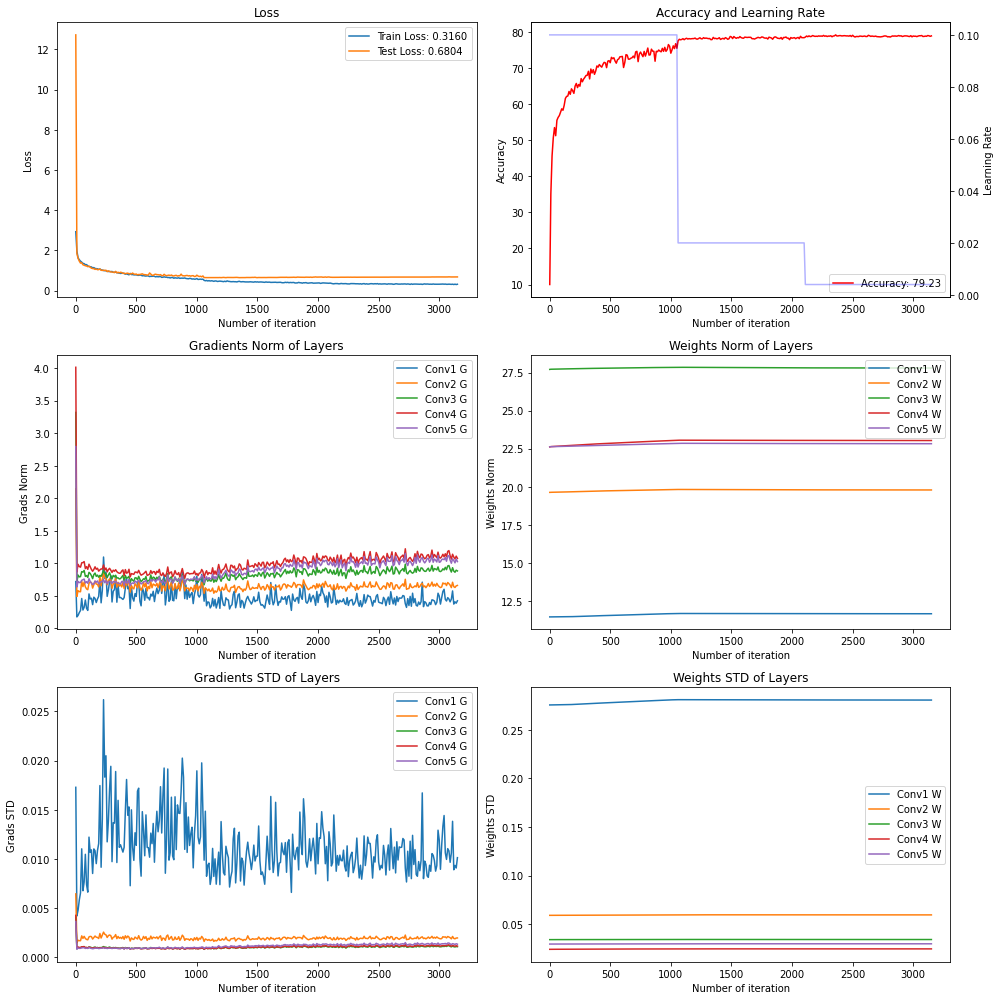

In [12]:
plot_train_test()

Weight 	epoch:0 	conv norm:136.786407 	conv std:0.028360 	conv max:0.470021 	conv  min:-0.470074
Weight 	epoch:1 	conv norm:136.753189 	conv std:0.028353 	conv max:0.494681 	conv  min:-0.482091
Weight 	epoch:21 	conv norm:135.840195 	conv std:0.028164 	conv max:0.654034 	conv  min:-0.583805
Weight 	epoch:42 	conv norm:135.582581 	conv std:0.028111 	conv max:0.675509 	conv  min:-0.590317
Weight 	epoch:63 	conv norm:135.527039 	conv std:0.028099 	conv max:0.669936 	conv  min:-0.589733


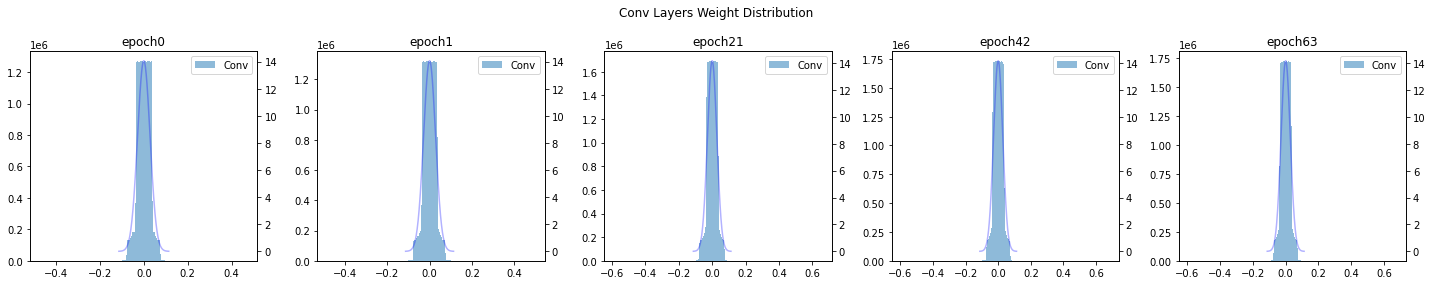

In [13]:
plot_hist(model)

In [14]:
class AlexNet_LNBN_FCN(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(AlexNet_LNBN_FCN, self).__init__()
        
        self.features = nn.Sequential(
            collections.OrderedDict(
                [
                    ("ln1", LayerNorm(args['batch_size'])),
                    ("conv1", nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1, bias=BIAS)),
                    ("bn1", nn.BatchNorm2d(64)),
                    ("relu1", nn.ReLU(inplace=True)),
                    ("pool1", nn.MaxPool2d(kernel_size=2)),
                    ("ln2", LayerNorm(args['batch_size'])),
                    ("conv2", nn.Conv2d(64, 192, kernel_size=3, padding=1, bias=BIAS)),
                    ("bn2", nn.BatchNorm2d(192)),
                    ("relu2", nn.ReLU(inplace=True)),
                    ("pool2", nn.MaxPool2d(kernel_size=2)),
                    ("ln3", LayerNorm(args['batch_size'])),
                    ("conv3", nn.Conv2d(192, 384, kernel_size=3, padding=1, bias=BIAS)),
                    ("bn3", nn.BatchNorm2d(384)),
                    ("relu3", nn.ReLU(inplace=True)),
                    ("ln4", LayerNorm(args['batch_size'])),
                    ("conv4", nn.Conv2d(384, 256, kernel_size=3, padding=1, bias=BIAS)),
                    ("bn4", nn.BatchNorm2d(256)),
                    ("relu4", nn.ReLU(inplace=True)),
                    ("ln5", LayerNorm(args['batch_size'])),
                    ("conv5", nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=BIAS)),
                    ("bn5", nn.BatchNorm2d(256)),
                    ("relu5", nn.ReLU(inplace=True)),
                    ("pool3", nn.MaxPool2d(kernel_size=2))
                ]
            )
        )
        self.classifier = nn.Sequential(
            collections.OrderedDict(
                [
                    ("fc1", nn.Conv2d(256 * 2 * 2, 4096, kernel_size=1, bias=BIAS)),
                    ("bn6", nn.BatchNorm2d(4096)),
                    ("relu6", nn.ReLU(inplace=True)),
                    ("fc2", nn.Conv2d(4096, 4096, kernel_size=1, bias=BIAS)),
                    ("bn7", nn.BatchNorm2d(4096)),
                    ("relu7", nn.ReLU(inplace=True)),
                    ("fc3", nn.Conv2d(4096, num_classes, kernel_size=1, bias=BIAS)),
                    ("relu8", nn.ReLU(inplace=True)),
                    ("bn8", nn.BatchNorm2d(num_classes))
                ]
            )
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.shape[0], -1)
        x = x.reshape((x.shape[0], x.shape[1], 1, 1)) # (batch, 256*2*2, 1, 1)
        x = self.classifier(x)
        return x.view(x.size(0), -1)
    
model = AlexNet_LNBN_FCN()

#for name, param in model.named_parameters():
#    if param.requires_grad:
#        print(name, param.data.size())

#summary(model, (1, 3, 32, 32))

In [15]:
run(model, 'SGD', 'Step', 'uniform')

SGD	Step
features.ln1.scale True torch.Size([1000])
features.ln1.shift True torch.Size([1000])
features.conv1.weight True torch.Size([64, 3, 3, 3])
features.bn1.weight True torch.Size([64])
features.bn1.bias True torch.Size([64])
features.ln2.scale True torch.Size([1000])
features.ln2.shift True torch.Size([1000])
features.conv2.weight True torch.Size([192, 64, 3, 3])
features.bn2.weight True torch.Size([192])
features.bn2.bias True torch.Size([192])
features.ln3.scale True torch.Size([1000])
features.ln3.shift True torch.Size([1000])
features.conv3.weight True torch.Size([384, 192, 3, 3])
features.bn3.weight True torch.Size([384])
features.bn3.bias True torch.Size([384])
features.ln4.scale True torch.Size([1000])
features.ln4.shift True torch.Size([1000])
features.conv4.weight True torch.Size([256, 384, 3, 3])
features.bn4.weight True torch.Size([256])
features.bn4.bias True torch.Size([256])
features.ln5.scale True torch.Size([1000])
features.ln5.shift True torch.Size([1000])
feature

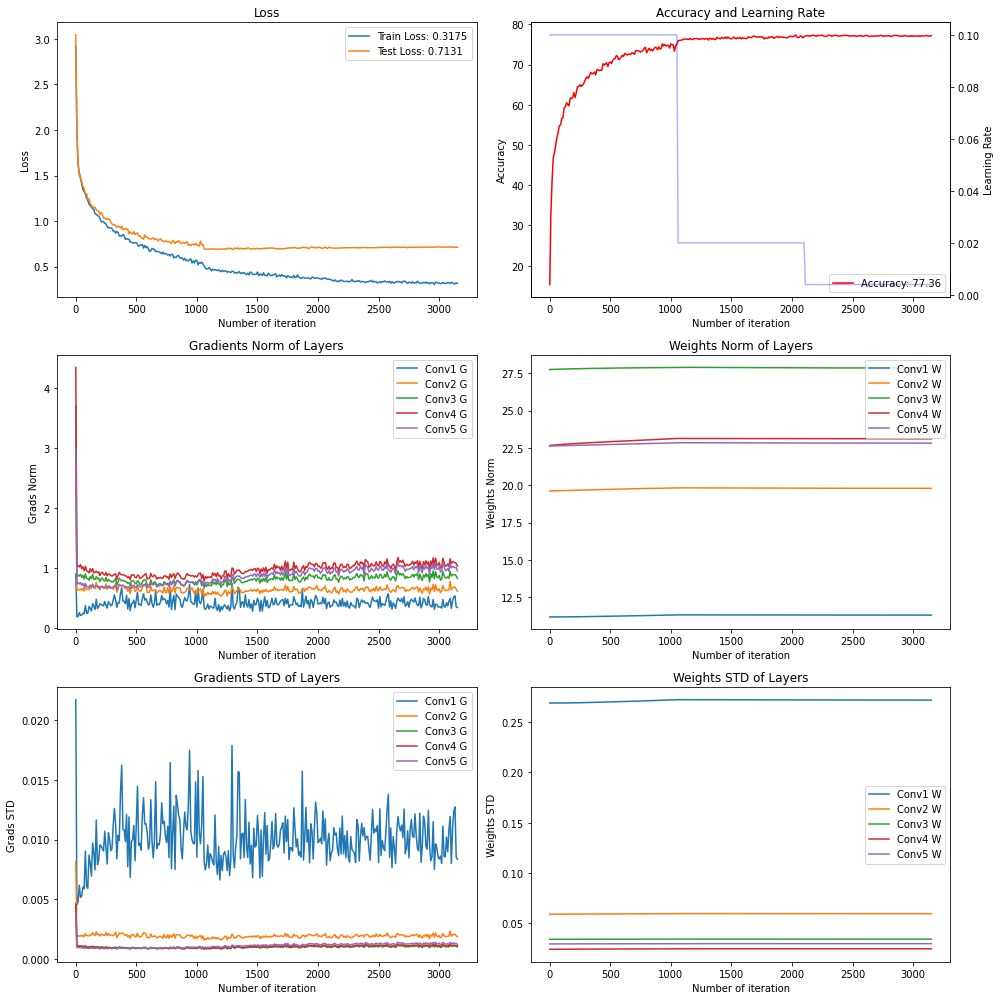

In [16]:
plot_train_test()

Weight 	epoch:0 	conv norm:136.775803 	conv std:0.028358 	conv max:0.471353 	conv  min:-0.470660
Weight 	epoch:1 	conv norm:136.747726 	conv std:0.028352 	conv max:0.489180 	conv  min:-0.489186
Weight 	epoch:21 	conv norm:135.821426 	conv std:0.028160 	conv max:0.649749 	conv  min:-0.578120
Weight 	epoch:42 	conv norm:135.561798 	conv std:0.028106 	conv max:0.672382 	conv  min:-0.601305
Weight 	epoch:63 	conv norm:135.506149 	conv std:0.028095 	conv max:0.670163 	conv  min:-0.599108


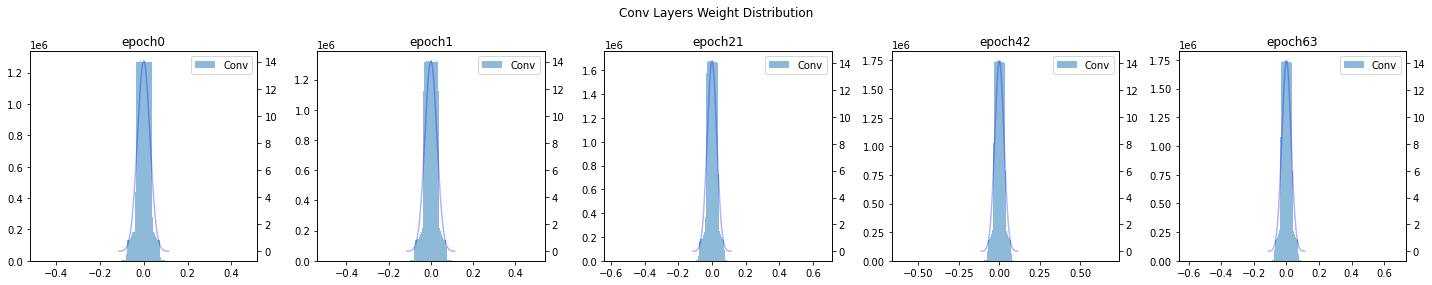

In [17]:
plot_hist(model)

In [18]:
class AlexNet_LN1BN_FCN(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(AlexNet_LN1BN_FCN, self).__init__()
        
        self.features = nn.Sequential(
            collections.OrderedDict(
                [
                    ("ln1", LayerNorm()),
                    ("conv1", nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1, bias=BIAS)),
                    ("bn1", nn.BatchNorm2d(64)),
                    ("relu1", nn.ReLU(inplace=True)),
                    ("pool1", nn.MaxPool2d(kernel_size=2)),
                    ("ln2", LayerNorm()),
                    ("conv2", nn.Conv2d(64, 192, kernel_size=3, padding=1, bias=BIAS)),
                    ("bn2", nn.BatchNorm2d(192)),
                    ("relu2", nn.ReLU(inplace=True)),
                    ("pool2", nn.MaxPool2d(kernel_size=2)),
                    ("ln3", LayerNorm()),
                    ("conv3", nn.Conv2d(192, 384, kernel_size=3, padding=1, bias=BIAS)),
                    ("bn3", nn.BatchNorm2d(384)),
                    ("relu3", nn.ReLU(inplace=True)),
                    ("ln4", LayerNorm()),
                    ("conv4", nn.Conv2d(384, 256, kernel_size=3, padding=1, bias=BIAS)),
                    ("bn4", nn.BatchNorm2d(256)),
                    ("relu4", nn.ReLU(inplace=True)),
                    ("ln5", LayerNorm()),
                    ("conv5", nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=BIAS)),
                    ("bn5", nn.BatchNorm2d(256)),
                    ("relu5", nn.ReLU(inplace=True)),
                    ("pool3", nn.MaxPool2d(kernel_size=2))
                ]
            )
        )
        self.classifier = nn.Sequential(
            collections.OrderedDict(
                [
                    ("fc1", nn.Conv2d(256 * 2 * 2, 4096, kernel_size=1, bias=BIAS)),
                    ("bn6", nn.BatchNorm2d(4096)),
                    ("relu6", nn.ReLU(inplace=True)),
                    ("fc2", nn.Conv2d(4096, 4096, kernel_size=1, bias=BIAS)),
                    ("bn7", nn.BatchNorm2d(4096)),
                    ("relu7", nn.ReLU(inplace=True)),
                    ("fc3", nn.Conv2d(4096, num_classes, kernel_size=1, bias=BIAS)),
                    ("relu8", nn.ReLU(inplace=True)),
                    ("bn8", nn.BatchNorm2d(num_classes))
                ]
            )
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.shape[0], -1)
        x = x.reshape((x.shape[0], x.shape[1], 1, 1)) # (batch, 256*2*2, 1, 1)
        x = self.classifier(x)
        return x.view(x.size(0), -1)
    
model = AlexNet_LN1BN_FCN()

#for name, param in model.named_parameters():
#    if param.requires_grad:
#        print(name, param.data.size())

#summary(model, (1, 3, 32, 32))

In [19]:
run(model, 'SGD', 'Step', 'uniform')

SGD	Step
features.ln1.scale True torch.Size([1])
features.ln1.shift True torch.Size([1])
features.conv1.weight True torch.Size([64, 3, 3, 3])
features.bn1.weight True torch.Size([64])
features.bn1.bias True torch.Size([64])
features.ln2.scale True torch.Size([1])
features.ln2.shift True torch.Size([1])
features.conv2.weight True torch.Size([192, 64, 3, 3])
features.bn2.weight True torch.Size([192])
features.bn2.bias True torch.Size([192])
features.ln3.scale True torch.Size([1])
features.ln3.shift True torch.Size([1])
features.conv3.weight True torch.Size([384, 192, 3, 3])
features.bn3.weight True torch.Size([384])
features.bn3.bias True torch.Size([384])
features.ln4.scale True torch.Size([1])
features.ln4.shift True torch.Size([1])
features.conv4.weight True torch.Size([256, 384, 3, 3])
features.bn4.weight True torch.Size([256])
features.bn4.bias True torch.Size([256])
features.ln5.scale True torch.Size([1])
features.ln5.shift True torch.Size([1])
features.conv5.weight True torch.Size

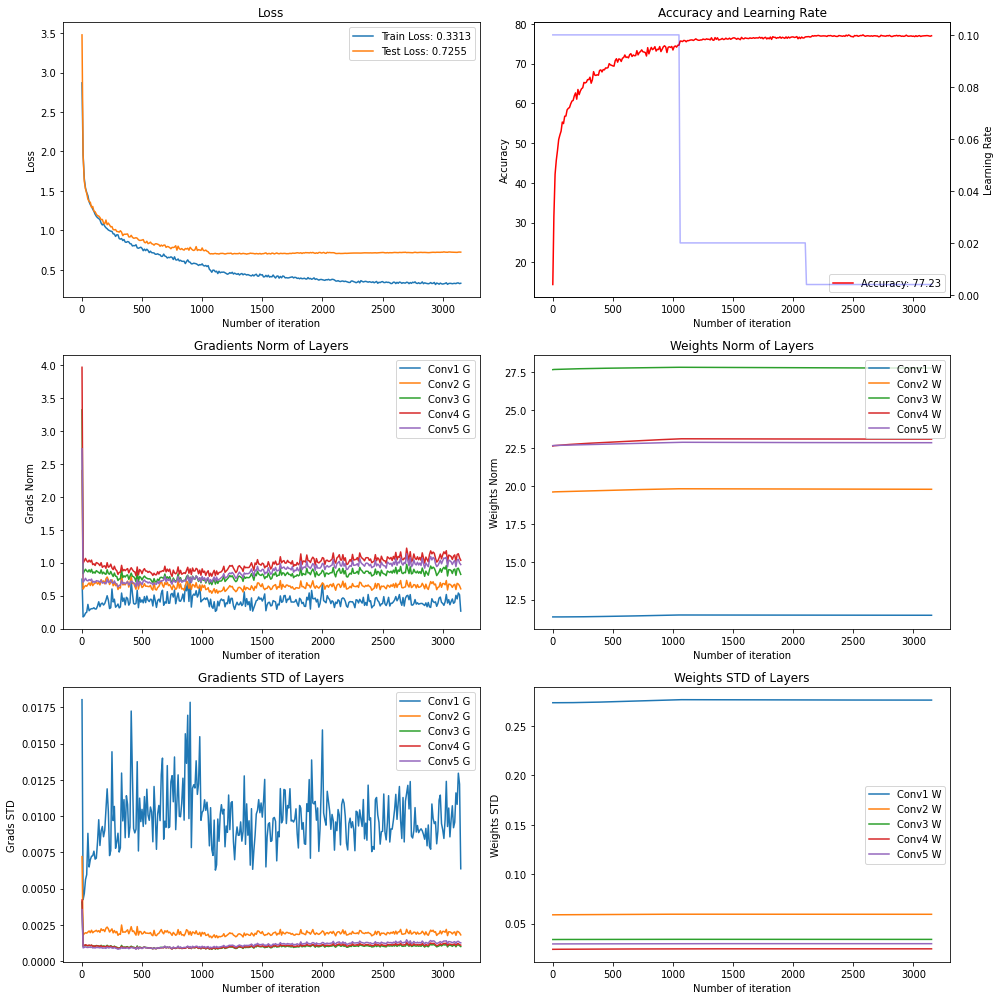

In [20]:
plot_train_test()

Weight 	epoch:0 	conv norm:136.764801 	conv std:0.028356 	conv max:0.470429 	conv  min:-0.470697
Weight 	epoch:1 	conv norm:136.734253 	conv std:0.028349 	conv max:0.489136 	conv  min:-0.482689
Weight 	epoch:21 	conv norm:135.804749 	conv std:0.028157 	conv max:0.651526 	conv  min:-0.635099
Weight 	epoch:42 	conv norm:135.544785 	conv std:0.028103 	conv max:0.668129 	conv  min:-0.664668
Weight 	epoch:63 	conv norm:135.489105 	conv std:0.028091 	conv max:0.669565 	conv  min:-0.668212


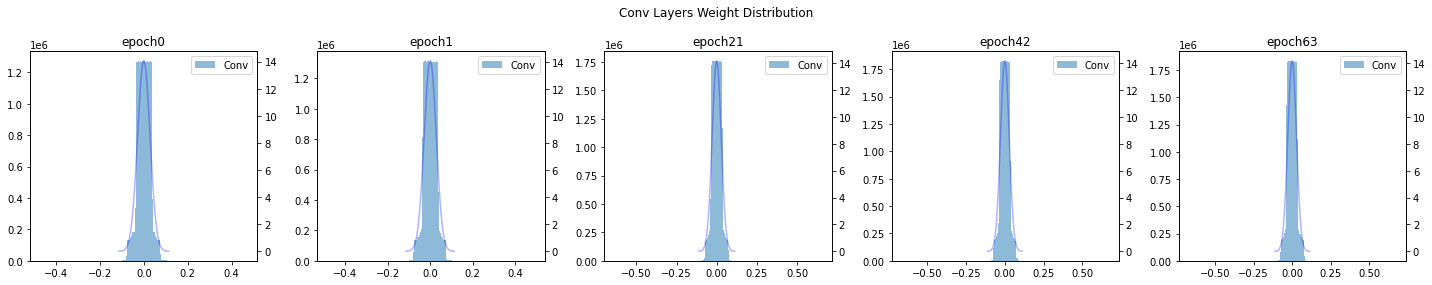

In [21]:
plot_hist(model)

In [22]:
class AlexNet_BN_FAN(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(AlexNet_BN_FAN, self).__init__()
        
        self.features = nn.Sequential(
            collections.OrderedDict(
                [
                    ("conv1", Adder2D(3, 64, kernel_size=3, stride=2, padding=1, bias=BIAS)),
                    ("bn1", nn.BatchNorm2d(64)),
                    ("relu1", nn.ReLU(inplace=True)),
                    ("pool1", nn.MaxPool2d(kernel_size=2)),
                    ("conv2", Adder2D(64, 192, kernel_size=3, padding=1, bias=BIAS)),
                    ("bn2", nn.BatchNorm2d(192)),
                    ("relu2", nn.ReLU(inplace=True)),
                    ("pool2", nn.MaxPool2d(kernel_size=2)),
                    ("conv3", Adder2D(192, 384, kernel_size=3, padding=1, bias=BIAS)),
                    ("bn3", nn.BatchNorm2d(384)),
                    ("relu3", nn.ReLU(inplace=True)),
                    ("conv4", Adder2D(384, 256, kernel_size=3, padding=1, bias=BIAS)),
                    ("bn4", nn.BatchNorm2d(256)),
                    ("relu4", nn.ReLU(inplace=True)),
                    ("conv5", Adder2D(256, 256, kernel_size=3, padding=1, bias=BIAS)),
                    ("bn5", nn.BatchNorm2d(256)),
                    ("relu5", nn.ReLU(inplace=True)),
                    ("pool3", nn.MaxPool2d(kernel_size=2))
                ]
            )
        )
        self.classifier = nn.Sequential(
            collections.OrderedDict(
                [
                    ("fc1", nn.Conv2d(256 * 2 * 2, 4096, kernel_size=1, bias=BIAS)),
                    ("bn6", nn.BatchNorm2d(4096)),
                    ("relu6", nn.ReLU(inplace=True)),
                    ("fc2", nn.Conv2d(4096, 4096, kernel_size=1, bias=BIAS)),
                    ("bn7", nn.BatchNorm2d(4096)),
                    ("relu7", nn.ReLU(inplace=True)),
                    ("fc3", nn.Conv2d(4096, num_classes, kernel_size=1, bias=BIAS)),
                    ("relu8", nn.ReLU(inplace=True)),
                    ("bn8", nn.BatchNorm2d(num_classes))
                ]
            )
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.shape[0], -1)
        x = x.reshape((x.shape[0], x.shape[1], 1, 1)) # (batch, 256*2*2, 1, 1)
        x = self.classifier(x)
        return x.view(x.size(0), -1)
    
model = AlexNet_BN_FAN()

#for name, param in model.named_parameters():
#    if param.requires_grad:
#        print(name, param.data.size())

In [23]:
run(model, 'SGD', 'Step', 'uniform')

SGD	Step
features.conv1.adder True torch.Size([64, 3, 3, 3])
features.bn1.weight True torch.Size([64])
features.bn1.bias True torch.Size([64])
features.conv2.adder True torch.Size([192, 64, 3, 3])
features.bn2.weight True torch.Size([192])
features.bn2.bias True torch.Size([192])
features.conv3.adder True torch.Size([384, 192, 3, 3])
features.bn3.weight True torch.Size([384])
features.bn3.bias True torch.Size([384])
features.conv4.adder True torch.Size([256, 384, 3, 3])
features.bn4.weight True torch.Size([256])
features.bn4.bias True torch.Size([256])
features.conv5.adder True torch.Size([256, 256, 3, 3])
features.bn5.weight True torch.Size([256])
features.bn5.bias True torch.Size([256])
classifier.fc1.weight True torch.Size([4096, 1024, 1, 1])
classifier.bn6.weight True torch.Size([4096])
classifier.bn6.bias True torch.Size([4096])
classifier.fc2.weight True torch.Size([4096, 4096, 1, 1])
classifier.bn7.weight True torch.Size([4096])
classifier.bn7.bias True torch.Size([4096])
classi

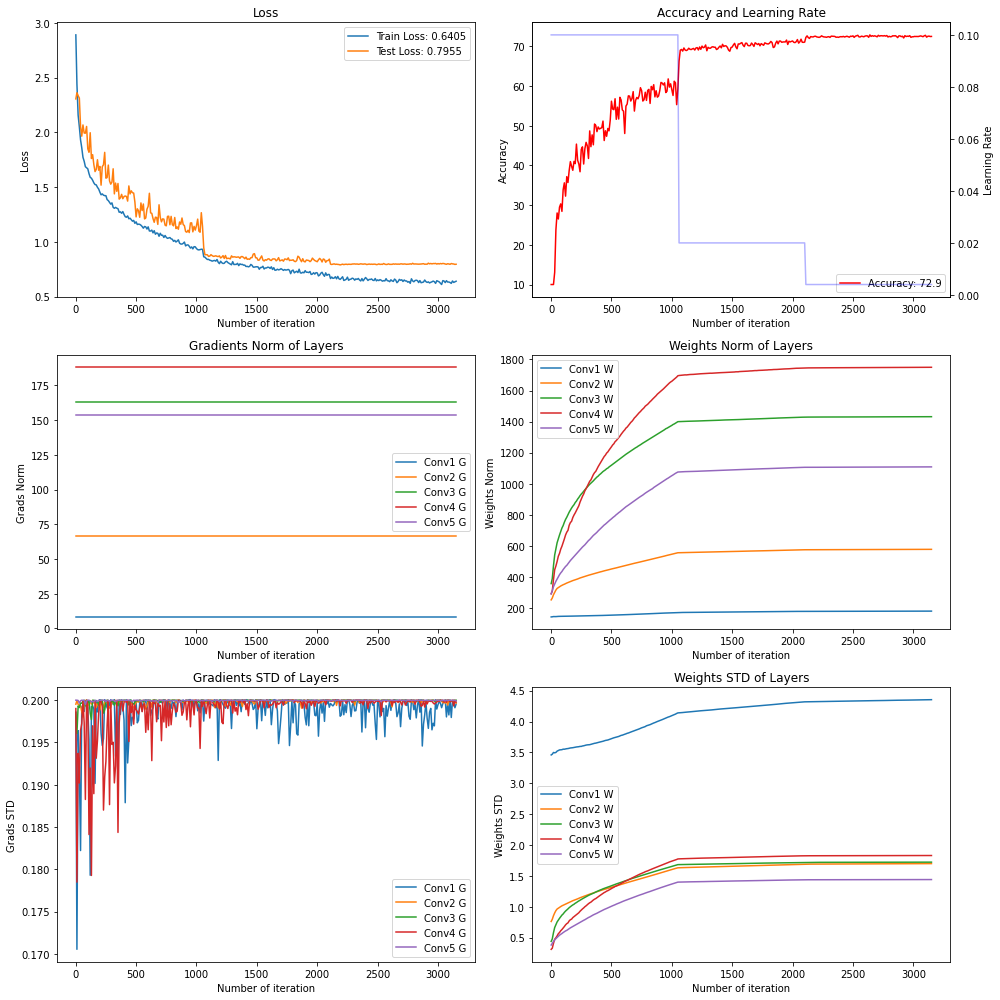

In [24]:
plot_train_test()

Weight 	epoch:0 	adder norm:619.076111	adder std:0.412678	adder max:6.082631	adder min:-6.061331
Weight 	epoch:0 	conv norm:128.049591 	conv std:0.027934 	conv max:0.076547 	conv  min:-0.076546
Weight 	epoch:1 	adder norm:955.935791	adder std:0.633092	adder max:12.754633	adder min:-8.256948
Weight 	epoch:1 	conv norm:127.997055 	conv std:0.027923 	conv max:0.080048 	conv  min:-0.086995
Weight 	epoch:21 	adder norm:2515.426025	adder std:1.656619	adder max:41.024498	adder min:-50.348976
Weight 	epoch:21 	conv norm:126.774246 	conv std:0.027656 	conv max:0.083420 	conv  min:-0.086109
Weight 	epoch:42 	adder norm:2583.444092	adder std:1.700509	adder max:41.310066	adder min:-49.087097
Weight 	epoch:42 	conv norm:126.514420 	conv std:0.027599 	conv max:0.082763 	conv  min:-0.085963
Weight 	epoch:63 	adder norm:2589.597900	adder std:1.704365	adder max:41.286285	adder min:-48.539478
Weight 	epoch:63 	conv norm:126.461807 	conv std:0.027588 	conv max:0.082507 	conv  min:-0.085957


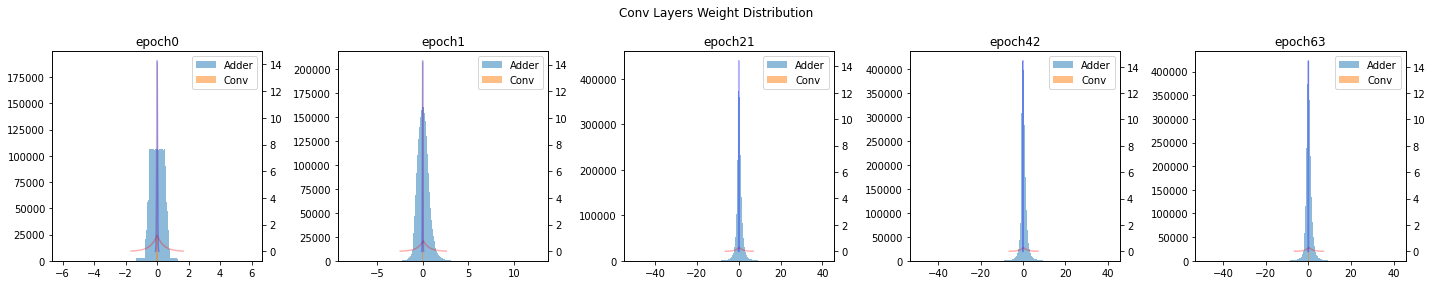

In [25]:
plot_hist(model)

In [26]:
class AlexNet_LNBN_FAN(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(AlexNet_LNBN_FAN, self).__init__()
        
        self.features = nn.Sequential(
            collections.OrderedDict(
                [
                    ("ln1", LayerNorm(args['batch_size'])),
                    ("conv1", Adder2D(3, 64, kernel_size=3, stride=2, padding=1, bias=BIAS)),
                    ("bn1", nn.BatchNorm2d(64)),
                    ("relu1", nn.ReLU(inplace=True)),
                    ("pool1", nn.MaxPool2d(kernel_size=2)),
                    ("ln2", LayerNorm(args['batch_size'])),
                    ("conv2", Adder2D(64, 192, kernel_size=3, padding=1, bias=BIAS)),
                    ("bn2", nn.BatchNorm2d(192)),
                    ("relu2", nn.ReLU(inplace=True)),
                    ("pool2", nn.MaxPool2d(kernel_size=2)),
                    ("ln3", LayerNorm(args['batch_size'])),
                    ("conv3", Adder2D(192, 384, kernel_size=3, padding=1, bias=BIAS)),
                    ("bn3", nn.BatchNorm2d(384)),
                    ("relu3", nn.ReLU(inplace=True)),
                    ("ln4", LayerNorm(args['batch_size'])),
                    ("conv4", Adder2D(384, 256, kernel_size=3, padding=1, bias=BIAS)),
                    ("bn4", nn.BatchNorm2d(256)),
                    ("relu4", nn.ReLU(inplace=True)),
                    ("ln5", LayerNorm(args['batch_size'])),
                    ("conv5", Adder2D(256, 256, kernel_size=3, padding=1, bias=BIAS)),
                    ("bn5", nn.BatchNorm2d(256)),
                    ("relu5", nn.ReLU(inplace=True)),
                    ("pool3", nn.MaxPool2d(kernel_size=2))
                ]
            )
        )
        self.classifier = nn.Sequential(
            collections.OrderedDict(
                [
                    ("fc1", nn.Conv2d(256 * 2 * 2, 4096, kernel_size=1, bias=BIAS)),
                    ("bn6", nn.BatchNorm2d(4096)),
                    ("relu6", nn.ReLU(inplace=True)),
                    ("fc2", nn.Conv2d(4096, 4096, kernel_size=1, bias=BIAS)),
                    ("bn7", nn.BatchNorm2d(4096)),
                    ("relu7", nn.ReLU(inplace=True)),
                    ("fc3", nn.Conv2d(4096, num_classes, kernel_size=1, bias=BIAS)),
                    ("relu8", nn.ReLU(inplace=True)),
                    ("bn8", nn.BatchNorm2d(num_classes))
                ]
            )
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.shape[0], -1)
        x = x.reshape((x.shape[0], x.shape[1], 1, 1)) # (batch, 256*2*2, 1, 1)
        x = self.classifier(x)
        return x.view(x.size(0), -1)
    
model = AlexNet_LNBN_FAN()

#for name, param in model.named_parameters():
#    if param.requires_grad:
#        print(name, param.data.size())

In [27]:
run(model, 'SGD', 'Step', 'uniform')

SGD	Step
features.ln1.scale True torch.Size([1000])
features.ln1.shift True torch.Size([1000])
features.conv1.adder True torch.Size([64, 3, 3, 3])
features.bn1.weight True torch.Size([64])
features.bn1.bias True torch.Size([64])
features.ln2.scale True torch.Size([1000])
features.ln2.shift True torch.Size([1000])
features.conv2.adder True torch.Size([192, 64, 3, 3])
features.bn2.weight True torch.Size([192])
features.bn2.bias True torch.Size([192])
features.ln3.scale True torch.Size([1000])
features.ln3.shift True torch.Size([1000])
features.conv3.adder True torch.Size([384, 192, 3, 3])
features.bn3.weight True torch.Size([384])
features.bn3.bias True torch.Size([384])
features.ln4.scale True torch.Size([1000])
features.ln4.shift True torch.Size([1000])
features.conv4.adder True torch.Size([256, 384, 3, 3])
features.bn4.weight True torch.Size([256])
features.bn4.bias True torch.Size([256])
features.ln5.scale True torch.Size([1000])
features.ln5.shift True torch.Size([1000])
features.co

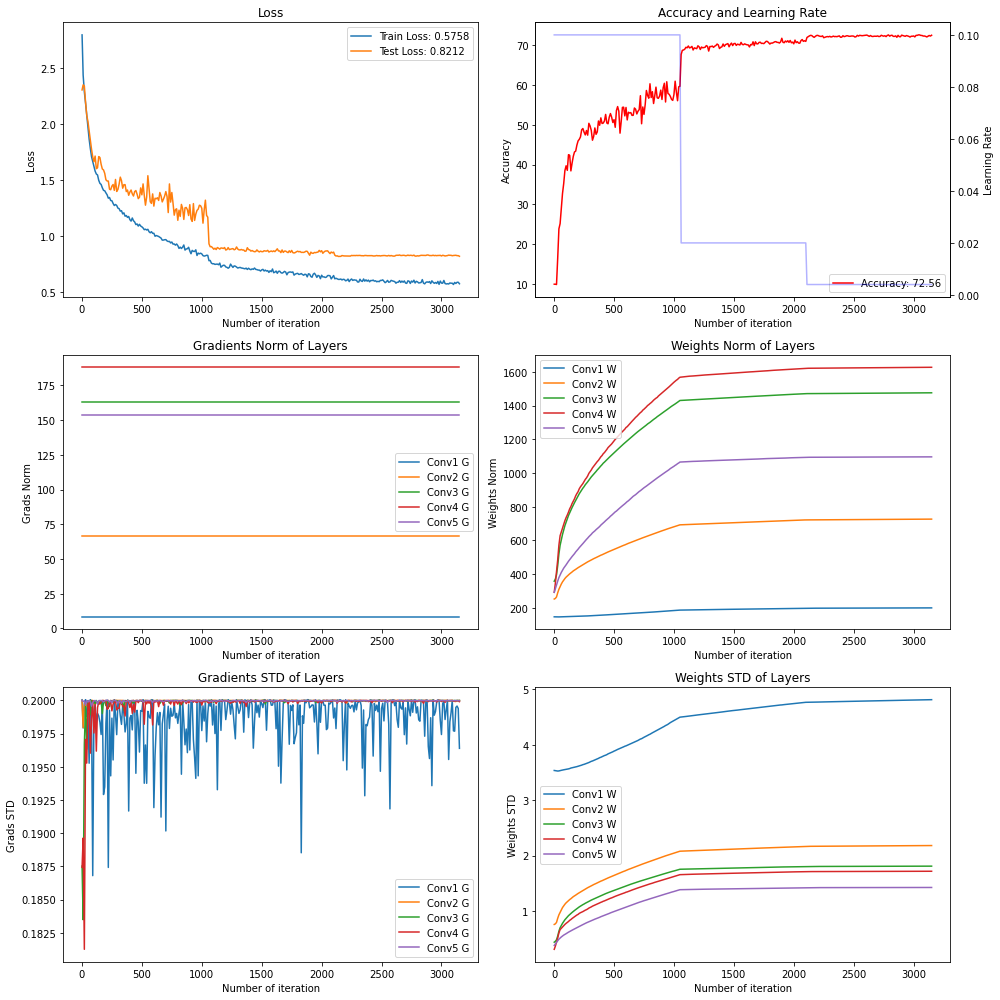

In [28]:
plot_train_test()

Weight 	epoch:0 	adder norm:620.036621	adder std:0.413318	adder max:6.083938	adder min:-6.084162
Weight 	epoch:0 	conv norm:128.062622 	conv std:0.027937 	conv max:0.076547 	conv  min:-0.076547
Weight 	epoch:1 	adder norm:1002.218933	adder std:0.667925	adder max:7.430593	adder min:-6.803697
Weight 	epoch:1 	conv norm:128.005814 	conv std:0.027925 	conv max:0.078169 	conv  min:-0.078566
Weight 	epoch:21 	adder norm:2480.453369	adder std:1.651626	adder max:28.220543	adder min:-34.108215
Weight 	epoch:21 	conv norm:126.785545 	conv std:0.027659 	conv max:0.082642 	conv  min:-0.083033
Weight 	epoch:42 	adder norm:2558.737793	adder std:1.703459	adder max:32.576687	adder min:-38.143227
Weight 	epoch:42 	conv norm:126.525208 	conv std:0.027602 	conv max:0.083035 	conv  min:-0.082535
Weight 	epoch:63 	adder norm:2567.778809	adder std:1.709434	adder max:33.593391	adder min:-38.105137
Weight 	epoch:63 	conv norm:126.472534 	conv std:0.027590 	conv max:0.082828 	conv  min:-0.082714


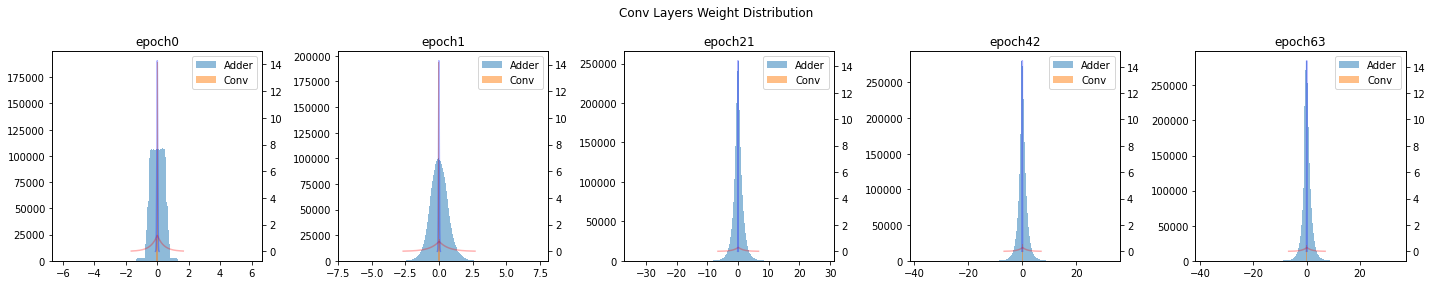

In [29]:
plot_hist(model)

In [30]:
class AlexNet_LNBN_FAN_WS(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(AlexNet_LNBN_FAN_WS, self).__init__()
        
        self.features = nn.Sequential(
            collections.OrderedDict(
                [
                    ("ln1", LayerNorm(args['batch_size'])),
                    ("conv1", adder2d(3, 64, kernel_size=3, stride=2, padding=1, bias=BIAS, aws=False)),
                    ("bn1", nn.BatchNorm2d(64)),
                    ("relu1", nn.ReLU(inplace=True)),
                    ("pool1", nn.MaxPool2d(kernel_size=2)),
                    ("ln2", LayerNorm(args['batch_size'])),
                    ("conv2", adder2d(64, 192, kernel_size=3, padding=1, bias=BIAS, aws=False)),
                    ("bn2", nn.BatchNorm2d(192)),
                    ("relu2", nn.ReLU(inplace=True)),
                    ("pool2", nn.MaxPool2d(kernel_size=2)),
                    ("ln3", LayerNorm(args['batch_size'])),
                    ("conv3", adder2d(192, 384, kernel_size=3, padding=1, bias=BIAS, aws=False)),
                    ("bn3", nn.BatchNorm2d(384)),
                    ("relu3", nn.ReLU(inplace=True)),
                    ("ln4", LayerNorm(args['batch_size'])),
                    ("conv4", adder2d(384, 256, kernel_size=3, padding=1, bias=BIAS, aws=False)),
                    ("bn4", nn.BatchNorm2d(256)),
                    ("relu4", nn.ReLU(inplace=True)),
                    ("ln5", LayerNorm(args['batch_size'])),
                    ("conv5", adder2d(256, 256, kernel_size=3, padding=1, bias=BIAS, aws=False)),
                    ("bn5", nn.BatchNorm2d(256)),
                    ("relu5", nn.ReLU(inplace=True)),
                    ("pool3", nn.MaxPool2d(kernel_size=2))
                ]
            )
        )
        self.classifier = nn.Sequential(
            collections.OrderedDict(
                [
                    ("fc1", nn.Conv2d(256 * 2 * 2, 4096, kernel_size=1, bias=BIAS)),
                    ("bn6", nn.BatchNorm2d(4096)),
                    ("relu6", nn.ReLU(inplace=True)),
                    ("fc2", nn.Conv2d(4096, 4096, kernel_size=1, bias=BIAS)),
                    ("bn7", nn.BatchNorm2d(4096)),
                    ("relu7", nn.ReLU(inplace=True)),
                    ("fc3", nn.Conv2d(4096, num_classes, kernel_size=1, bias=BIAS)),
                    ("relu8", nn.ReLU(inplace=True)),
                    ("bn8", nn.BatchNorm2d(num_classes))
                ]
            )
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.shape[0], -1)
        x = x.reshape((x.shape[0], x.shape[1], 1, 1)) # (batch, 256*2*2, 1, 1)
        x = self.classifier(x)
        return x.view(x.size(0), -1)
    
model = AlexNet_LNBN_FAN_WS()

#for name, param in model.named_parameters():
#    if param.requires_grad:
#        print(name, param.data.size())

In [31]:
run(model, 'SGD', 'Step', 'uniform')

SGD	Step
features.ln1.scale True torch.Size([1000])
features.ln1.shift True torch.Size([1000])
features.conv1.adder True torch.Size([64, 3, 3, 3])
features.bn1.weight True torch.Size([64])
features.bn1.bias True torch.Size([64])
features.ln2.scale True torch.Size([1000])
features.ln2.shift True torch.Size([1000])
features.conv2.adder True torch.Size([192, 64, 3, 3])
features.bn2.weight True torch.Size([192])
features.bn2.bias True torch.Size([192])
features.ln3.scale True torch.Size([1000])
features.ln3.shift True torch.Size([1000])
features.conv3.adder True torch.Size([384, 192, 3, 3])
features.bn3.weight True torch.Size([384])
features.bn3.bias True torch.Size([384])
features.ln4.scale True torch.Size([1000])
features.ln4.shift True torch.Size([1000])
features.conv4.adder True torch.Size([256, 384, 3, 3])
features.bn4.weight True torch.Size([256])
features.bn4.bias True torch.Size([256])
features.ln5.scale True torch.Size([1000])
features.ln5.shift True torch.Size([1000])
features.co

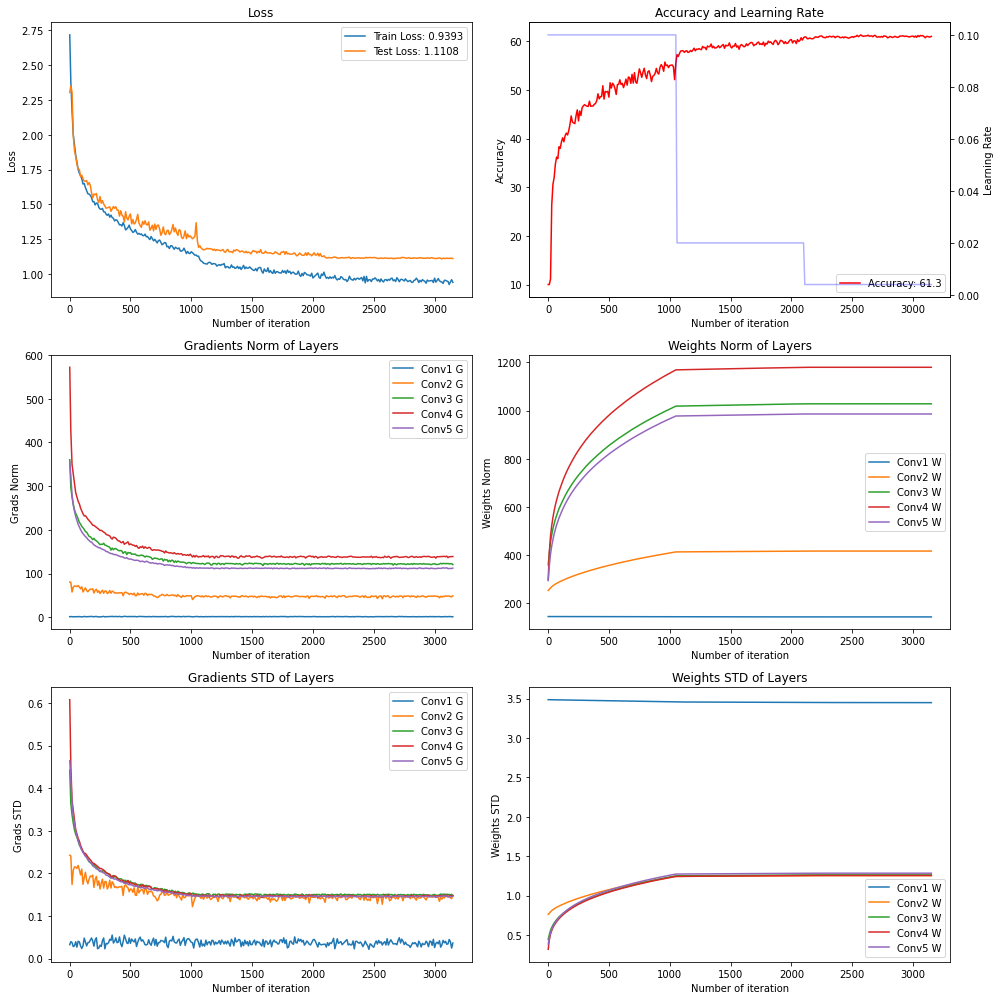

In [32]:
plot_train_test()

Weight 	epoch:0 	adder norm:619.647156	adder std:0.413058	adder max:6.085281	adder min:-6.079996
Weight 	epoch:0 	conv norm:128.065842 	conv std:0.027938 	conv max:0.076547 	conv  min:-0.076547
Weight 	epoch:1 	adder norm:978.756104	adder std:0.652441	adder max:6.299542	adder min:-6.302177
Weight 	epoch:1 	conv norm:128.014221 	conv std:0.027927 	conv max:0.080283 	conv  min:-0.079492
Weight 	epoch:21 	adder norm:1883.779663	adder std:1.255733	adder max:11.644384	adder min:-9.021602
Weight 	epoch:21 	conv norm:126.793800 	conv std:0.027660 	conv max:0.081971 	conv  min:-0.080696
Weight 	epoch:42 	adder norm:1900.792969	adder std:1.267074	adder max:12.032959	adder min:-9.241510
Weight 	epoch:42 	conv norm:126.532715 	conv std:0.027603 	conv max:0.082423 	conv  min:-0.081074
Weight 	epoch:63 	adder norm:1900.850586	adder std:1.267112	adder max:12.087058	adder min:-9.321836
Weight 	epoch:63 	conv norm:126.479889 	conv std:0.027592 	conv max:0.082497 	conv  min:-0.081166


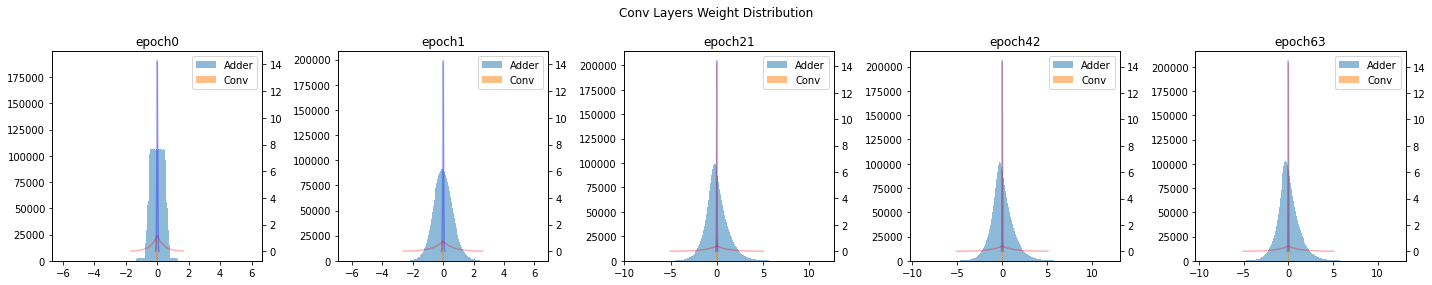

In [33]:
plot_hist(model)

In [34]:
class AlexNet_LNBN_FAN_AWS(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(AlexNet_LNBN_FAN_AWS, self).__init__()
        
        self.features = nn.Sequential(
            collections.OrderedDict(
                [
                    ("ln1", LayerNorm(args['batch_size'])),
                    ("conv1", adder2d(3, 64, kernel_size=3, stride=2, padding=1, bias=BIAS)),
                    ("bn1", nn.BatchNorm2d(64)),
                    ("relu1", nn.ReLU(inplace=True)),
                    ("pool1", nn.MaxPool2d(kernel_size=2)),
                    ("ln2", LayerNorm(args['batch_size'])),
                    ("conv2", adder2d(64, 192, kernel_size=3, padding=1, bias=BIAS)),
                    ("bn2", nn.BatchNorm2d(192)),
                    ("relu2", nn.ReLU(inplace=True)),
                    ("pool2", nn.MaxPool2d(kernel_size=2)),
                    ("ln3", LayerNorm(args['batch_size'])),
                    ("conv3", adder2d(192, 384, kernel_size=3, padding=1, bias=BIAS)),
                    ("bn3", nn.BatchNorm2d(384)),
                    ("relu3", nn.ReLU(inplace=True)),
                    ("ln4", LayerNorm(args['batch_size'])),
                    ("conv4", adder2d(384, 256, kernel_size=3, padding=1, bias=BIAS)),
                    ("bn4", nn.BatchNorm2d(256)),
                    ("relu4", nn.ReLU(inplace=True)),
                    ("ln5", LayerNorm(args['batch_size'])),
                    ("conv5", adder2d(256, 256, kernel_size=3, padding=1, bias=BIAS)),
                    ("bn5", nn.BatchNorm2d(256)),
                    ("relu5", nn.ReLU(inplace=True)),
                    ("pool3", nn.MaxPool2d(kernel_size=2))
                ]
            )
        )
        self.classifier = nn.Sequential(
            collections.OrderedDict(
                [
                    ("fc1", nn.Conv2d(256 * 2 * 2, 4096, kernel_size=1, bias=BIAS)),
                    ("bn6", nn.BatchNorm2d(4096)),
                    ("relu6", nn.ReLU(inplace=True)),
                    ("fc2", nn.Conv2d(4096, 4096, kernel_size=1, bias=BIAS)),
                    ("bn7", nn.BatchNorm2d(4096)),
                    ("relu7", nn.ReLU(inplace=True)),
                    ("fc3", nn.Conv2d(4096, num_classes, kernel_size=1, bias=BIAS)),
                    ("relu8", nn.ReLU(inplace=True)),
                    ("bn8", nn.BatchNorm2d(num_classes))
                ]
            )
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.shape[0], -1)
        x = x.reshape((x.shape[0], x.shape[1], 1, 1)) # (batch, 256*2*2, 1, 1)
        x = self.classifier(x)
        return x.view(x.size(0), -1)
    
model = AlexNet_LNBN_FAN_AWS()

#for name, param in model.named_parameters():
#    if param.requires_grad:
#        print(name, param.data.size())

In [35]:
run(model, 'SGD', 'Step', 'uniform', aws=True)

SGD	Step
normal params features.ln1.scale
normal params features.ln1.shift
normal params features.conv1.adder
tiny params features.conv1.scale
tiny params features.conv1.shift
normal params features.bn1.weight
normal params features.bn1.bias
normal params features.ln2.scale
normal params features.ln2.shift
normal params features.conv2.adder
tiny params features.conv2.scale
tiny params features.conv2.shift
normal params features.bn2.weight
normal params features.bn2.bias
normal params features.ln3.scale
normal params features.ln3.shift
normal params features.conv3.adder
tiny params features.conv3.scale
tiny params features.conv3.shift
normal params features.bn3.weight
normal params features.bn3.bias
normal params features.ln4.scale
normal params features.ln4.shift
normal params features.conv4.adder
tiny params features.conv4.scale
tiny params features.conv4.shift
normal params features.bn4.weight
normal params features.bn4.bias
normal params features.ln5.scale
normal params features.ln5

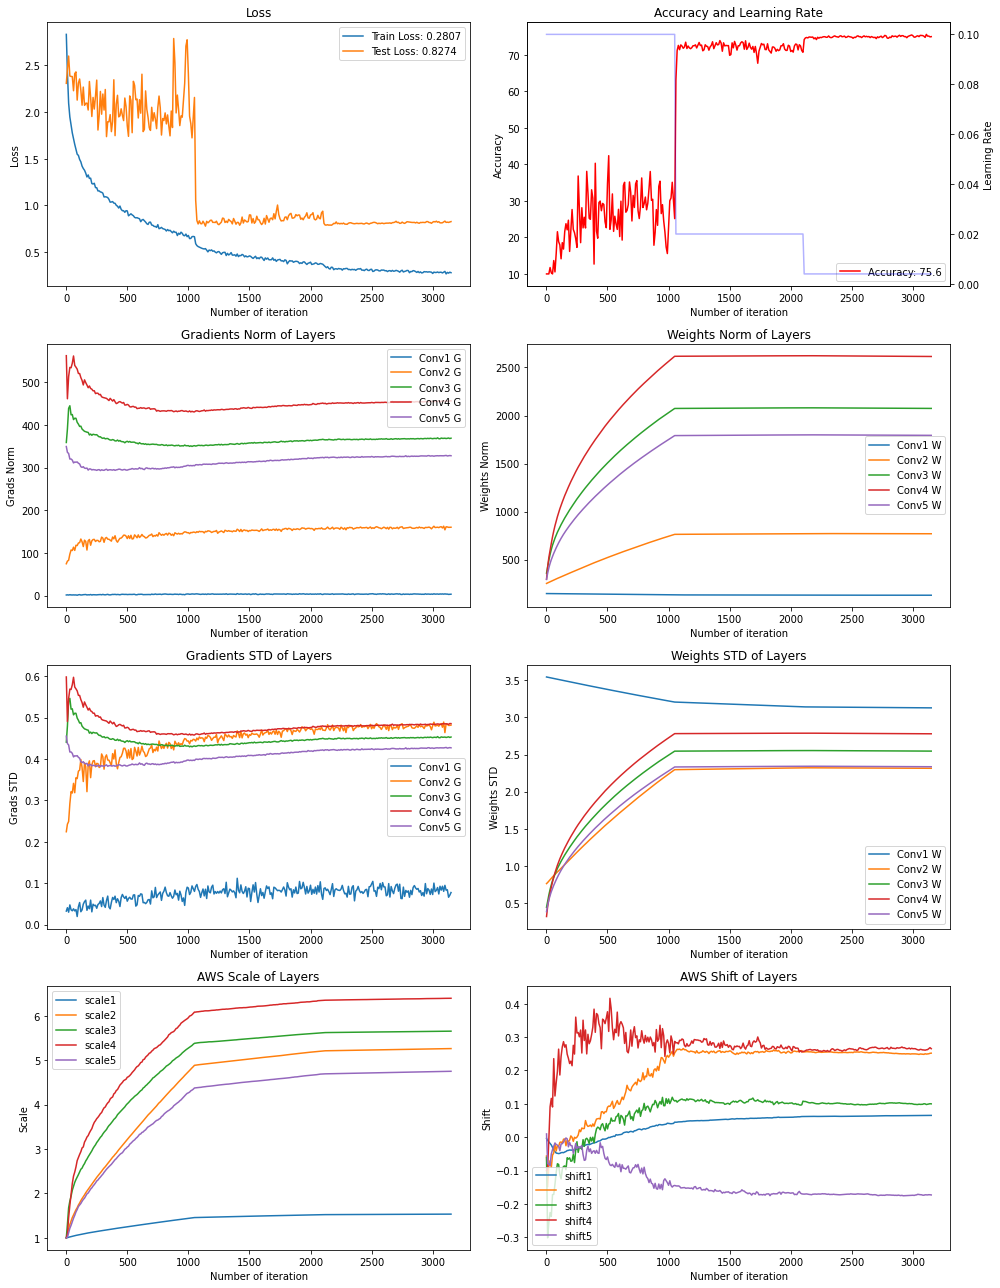

In [36]:
plot_train_test(aws=True)

Weight 	epoch:0 	adder norm:619.953491	adder std:0.413263	adder max:6.070054	adder min:-6.081982
Weight 	epoch:0 	conv norm:128.098785 	conv std:0.027945 	conv max:0.076547 	conv  min:-0.076547
Weight 	epoch:1 	adder norm:1164.424316	adder std:0.776208	adder max:9.241696	adder min:-7.248048
Weight 	epoch:1 	conv norm:127.491425 	conv std:0.027813 	conv max:0.080717 	conv  min:-0.083025
Weight 	epoch:21 	adder norm:3866.822510	adder std:2.577634	adder max:33.880802	adder min:-21.860344
Weight 	epoch:21 	conv norm:115.426239 	conv std:0.025181 	conv max:0.075905 	conv  min:-0.082483
Weight 	epoch:42 	adder norm:3880.224121	adder std:2.586568	adder max:36.531586	adder min:-23.320467
Weight 	epoch:42 	conv norm:113.037735 	conv std:0.024659 	conv max:0.075180 	conv  min:-0.080592
Weight 	epoch:63 	adder norm:3868.034424	adder std:2.578441	adder max:37.433796	adder min:-24.331699
Weight 	epoch:63 	conv norm:112.564690 	conv std:0.024556 	conv max:0.074802 	conv  min:-0.079268


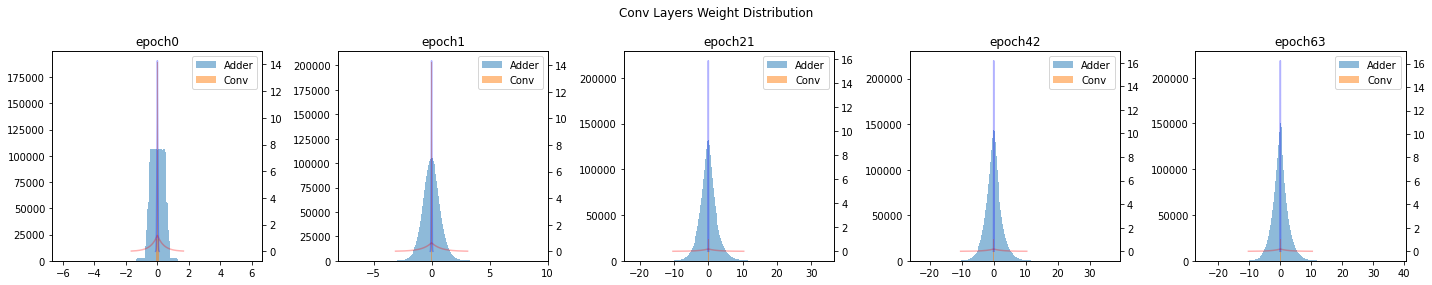

In [37]:
plot_hist(model)

In [38]:
class AlexNet_LN1BN_FAN(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(AlexNet_LN1BN_FAN, self).__init__()
        
        self.features = nn.Sequential(
            collections.OrderedDict(
                [
                    ("ln1", LayerNorm()),
                    ("conv1", Adder2D(3, 64, kernel_size=3, stride=2, padding=1, bias=BIAS)),
                    ("bn1", nn.BatchNorm2d(64)),
                    ("relu1", nn.ReLU(inplace=True)),
                    ("pool1", nn.MaxPool2d(kernel_size=2)),
                    ("ln2", LayerNorm()),
                    ("conv2", Adder2D(64, 192, kernel_size=3, padding=1, bias=BIAS)),
                    ("bn2", nn.BatchNorm2d(192)),
                    ("relu2", nn.ReLU(inplace=True)),
                    ("pool2", nn.MaxPool2d(kernel_size=2)),
                    ("ln3", LayerNorm()),
                    ("conv3", Adder2D(192, 384, kernel_size=3, padding=1, bias=BIAS)),
                    ("bn3", nn.BatchNorm2d(384)),
                    ("relu3", nn.ReLU(inplace=True)),
                    ("ln4", LayerNorm()),
                    ("conv4", Adder2D(384, 256, kernel_size=3, padding=1, bias=BIAS)),
                    ("bn4", nn.BatchNorm2d(256)),
                    ("relu4", nn.ReLU(inplace=True)),
                    ("ln5", LayerNorm()),
                    ("conv5", Adder2D(256, 256, kernel_size=3, padding=1, bias=BIAS)),
                    ("bn5", nn.BatchNorm2d(256)),
                    ("relu5", nn.ReLU(inplace=True)),
                    ("pool3", nn.MaxPool2d(kernel_size=2))
                ]
            )
        )
        self.classifier = nn.Sequential(
            collections.OrderedDict(
                [
                    ("fc1", nn.Conv2d(256 * 2 * 2, 4096, kernel_size=1, bias=BIAS)),
                    ("bn6", nn.BatchNorm2d(4096)),
                    ("relu6", nn.ReLU(inplace=True)),
                    ("fc2", nn.Conv2d(4096, 4096, kernel_size=1, bias=BIAS)),
                    ("bn7", nn.BatchNorm2d(4096)),
                    ("relu7", nn.ReLU(inplace=True)),
                    ("fc3", nn.Conv2d(4096, num_classes, kernel_size=1, bias=BIAS)),
                    ("relu8", nn.ReLU(inplace=True)),
                    ("bn8", nn.BatchNorm2d(num_classes))
                ]
            )
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.shape[0], -1)
        x = x.reshape((x.shape[0], x.shape[1], 1, 1)) # (batch, 256*2*2, 1, 1)
        x = self.classifier(x)
        return x.view(x.size(0), -1)
    
model = AlexNet_LN1BN_FAN()

#for name, param in model.named_parameters():
#    if param.requires_grad:
#        print(name, param.data.size())

In [39]:
run(model, 'SGD', 'Step', 'uniform')

SGD	Step
features.ln1.scale True torch.Size([1])
features.ln1.shift True torch.Size([1])
features.conv1.adder True torch.Size([64, 3, 3, 3])
features.bn1.weight True torch.Size([64])
features.bn1.bias True torch.Size([64])
features.ln2.scale True torch.Size([1])
features.ln2.shift True torch.Size([1])
features.conv2.adder True torch.Size([192, 64, 3, 3])
features.bn2.weight True torch.Size([192])
features.bn2.bias True torch.Size([192])
features.ln3.scale True torch.Size([1])
features.ln3.shift True torch.Size([1])
features.conv3.adder True torch.Size([384, 192, 3, 3])
features.bn3.weight True torch.Size([384])
features.bn3.bias True torch.Size([384])
features.ln4.scale True torch.Size([1])
features.ln4.shift True torch.Size([1])
features.conv4.adder True torch.Size([256, 384, 3, 3])
features.bn4.weight True torch.Size([256])
features.bn4.bias True torch.Size([256])
features.ln5.scale True torch.Size([1])
features.ln5.shift True torch.Size([1])
features.conv5.adder True torch.Size([256

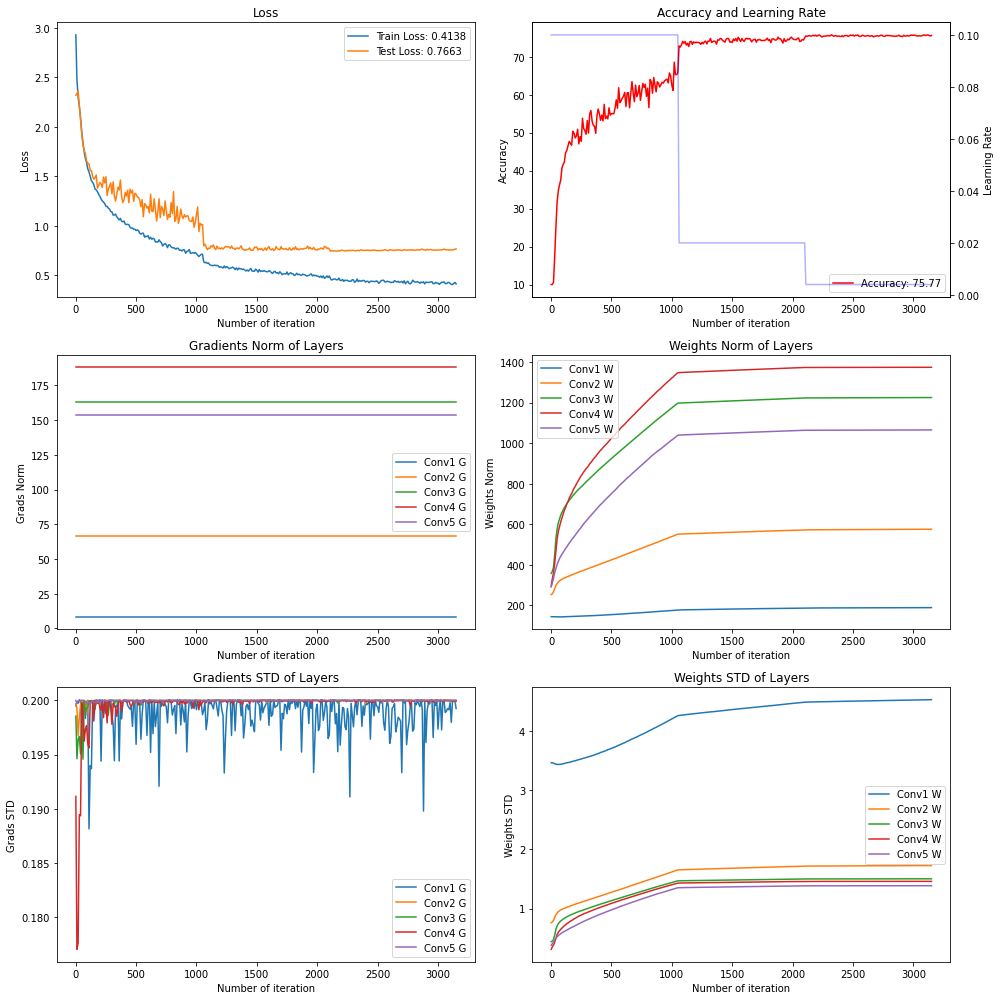

In [40]:
plot_train_test()

Weight 	epoch:0 	adder norm:619.142456	adder std:0.412722	adder max:6.084861	adder min:-6.083418
Weight 	epoch:0 	conv norm:128.074585 	conv std:0.027940 	conv max:0.076547 	conv  min:-0.076547
Weight 	epoch:1 	adder norm:941.032898	adder std:0.627274	adder max:6.872654	adder min:-6.775650
Weight 	epoch:1 	conv norm:128.021042 	conv std:0.027928 	conv max:0.080131 	conv  min:-0.080645
Weight 	epoch:21 	adder norm:2159.903564	adder std:1.439622	adder max:28.886662	adder min:-18.821527
Weight 	epoch:21 	conv norm:126.797813 	conv std:0.027661 	conv max:0.081554 	conv  min:-0.080792
Weight 	epoch:42 	adder norm:2208.609619	adder std:1.472152	adder max:27.702988	adder min:-19.852375
Weight 	epoch:42 	conv norm:126.537895 	conv std:0.027605 	conv max:0.081716 	conv  min:-0.084532
Weight 	epoch:63 	adder norm:2211.983643	adder std:1.474414	adder max:27.428230	adder min:-20.051712
Weight 	epoch:63 	conv norm:126.485252 	conv std:0.027593 	conv max:0.081804 	conv  min:-0.085723


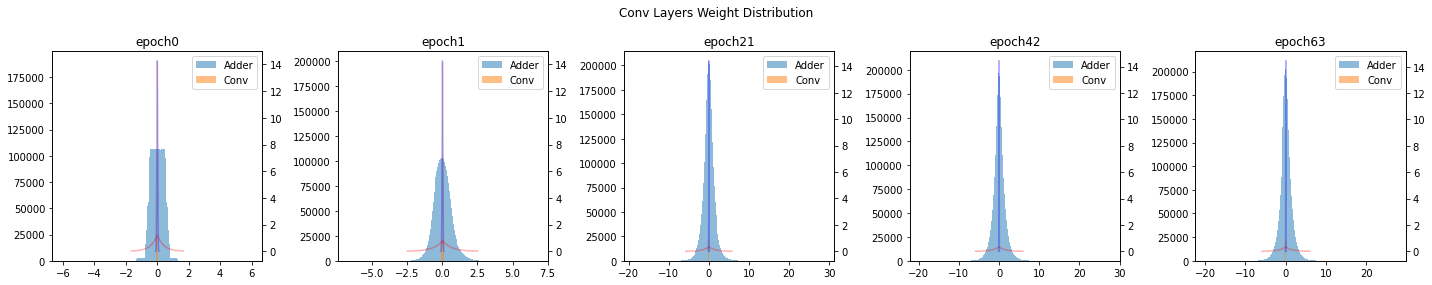

In [41]:
plot_hist(model)

In [42]:
class AlexNet_LN1BN_FAN_AWS(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(AlexNet_LN1BN_FAN_AWS, self).__init__()
        
        self.features = nn.Sequential(
            collections.OrderedDict(
                [
                    ("ln1", LayerNorm()),
                    ("conv1", adder2d(3, 64, kernel_size=3, stride=2, padding=1, bias=BIAS)),
                    ("bn1", nn.BatchNorm2d(64)),
                    ("relu1", nn.ReLU(inplace=True)),
                    ("pool1", nn.MaxPool2d(kernel_size=2)),
                    ("ln2", LayerNorm()),
                    ("conv2", adder2d(64, 192, kernel_size=3, padding=1, bias=BIAS)),
                    ("bn2", nn.BatchNorm2d(192)),
                    ("relu2", nn.ReLU(inplace=True)),
                    ("pool2", nn.MaxPool2d(kernel_size=2)),
                    ("ln3", LayerNorm()),
                    ("conv3", adder2d(192, 384, kernel_size=3, padding=1, bias=BIAS)),
                    ("bn3", nn.BatchNorm2d(384)),
                    ("relu3", nn.ReLU(inplace=True)),
                    ("ln4", LayerNorm()),
                    ("conv4", adder2d(384, 256, kernel_size=3, padding=1, bias=BIAS)),
                    ("bn4", nn.BatchNorm2d(256)),
                    ("relu4", nn.ReLU(inplace=True)),
                    ("ln5", LayerNorm()),
                    ("conv5", adder2d(256, 256, kernel_size=3, padding=1, bias=BIAS)),
                    ("bn5", nn.BatchNorm2d(256)),
                    ("relu5", nn.ReLU(inplace=True)),
                    ("pool3", nn.MaxPool2d(kernel_size=2))
                ]
            )
        )
        self.classifier = nn.Sequential(
            collections.OrderedDict(
                [
                    ("fc1", nn.Conv2d(256 * 2 * 2, 4096, kernel_size=1, bias=BIAS)),
                    ("bn6", nn.BatchNorm2d(4096)),
                    ("relu6", nn.ReLU(inplace=True)),
                    ("fc2", nn.Conv2d(4096, 4096, kernel_size=1, bias=BIAS)),
                    ("bn7", nn.BatchNorm2d(4096)),
                    ("relu7", nn.ReLU(inplace=True)),
                    ("fc3", nn.Conv2d(4096, num_classes, kernel_size=1, bias=BIAS)),
                    ("relu8", nn.ReLU(inplace=True)),
                    ("bn8", nn.BatchNorm2d(num_classes))
                ]
            )
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.shape[0], -1)
        x = x.reshape((x.shape[0], x.shape[1], 1, 1)) # (batch, 256*2*2, 1, 1)
        x = self.classifier(x)
        return x.view(x.size(0), -1)
    
model = AlexNet_LN1BN_FAN_AWS()

#for name, param in model.named_parameters():
#    if param.requires_grad:
#        print(name, param.data.size())

In [43]:
run(model, 'SGD', 'Step', 'uniform', aws=True)

SGD	Step
normal params features.ln1.scale
normal params features.ln1.shift
normal params features.conv1.adder
tiny params features.conv1.scale
tiny params features.conv1.shift
normal params features.bn1.weight
normal params features.bn1.bias
normal params features.ln2.scale
normal params features.ln2.shift
normal params features.conv2.adder
tiny params features.conv2.scale
tiny params features.conv2.shift
normal params features.bn2.weight
normal params features.bn2.bias
normal params features.ln3.scale
normal params features.ln3.shift
normal params features.conv3.adder
tiny params features.conv3.scale
tiny params features.conv3.shift
normal params features.bn3.weight
normal params features.bn3.bias
normal params features.ln4.scale
normal params features.ln4.shift
normal params features.conv4.adder
tiny params features.conv4.scale
tiny params features.conv4.shift
normal params features.bn4.weight
normal params features.bn4.bias
normal params features.ln5.scale
normal params features.ln5

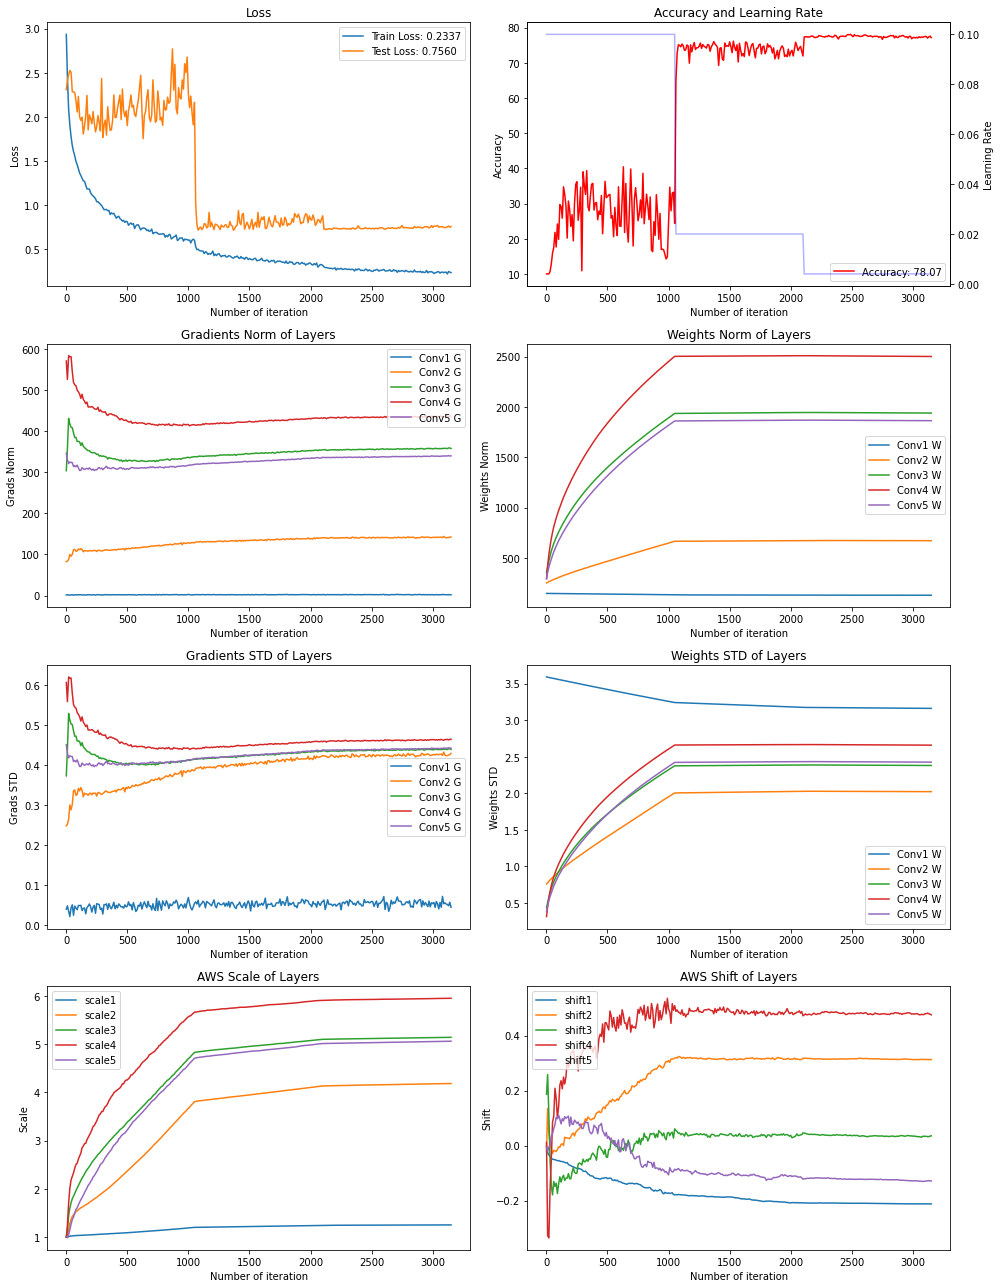

In [44]:
plot_train_test(aws=True)

Weight 	epoch:0 	adder norm:620.616211	adder std:0.413704	adder max:6.079289	adder min:-6.080462
Weight 	epoch:0 	conv norm:128.078842 	conv std:0.027941 	conv max:0.076547 	conv  min:-0.076547
Weight 	epoch:1 	adder norm:1148.935913	adder std:0.765884	adder max:8.494299	adder min:-7.531758
Weight 	epoch:1 	conv norm:127.461472 	conv std:0.027806 	conv max:0.079393 	conv  min:-0.078046
Weight 	epoch:21 	adder norm:3732.150635	adder std:2.487862	adder max:28.125401	adder min:-24.205294
Weight 	epoch:21 	conv norm:115.394142 	conv std:0.025174 	conv max:0.087814 	conv  min:-0.074327
Weight 	epoch:42 	adder norm:3747.366699	adder std:2.498005	adder max:29.482336	adder min:-24.684925
Weight 	epoch:42 	conv norm:113.004753 	conv std:0.024652 	conv max:0.084417 	conv  min:-0.072756
Weight 	epoch:63 	adder norm:3735.682373	adder std:2.490216	adder max:29.839853	adder min:-24.493120
Weight 	epoch:63 	conv norm:112.531677 	conv std:0.024549 	conv max:0.082853 	conv  min:-0.072285


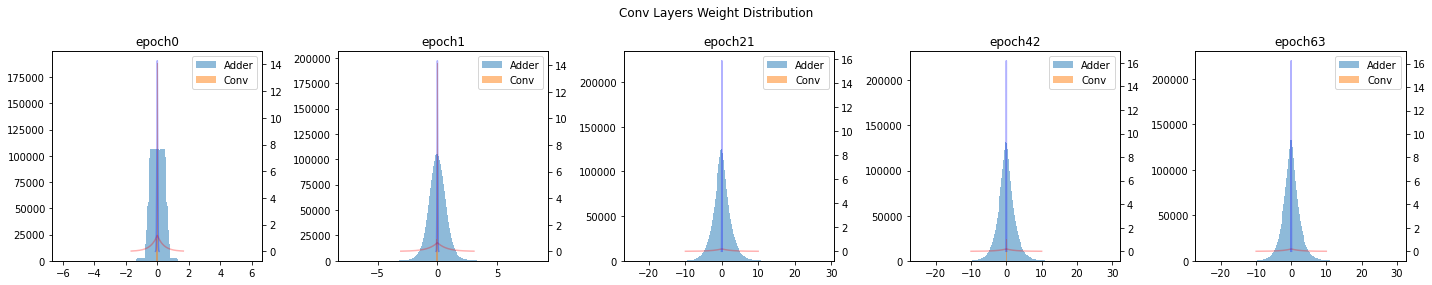

In [45]:
plot_hist(model)

In [7]:
class AlexNet_LN11BN_FAN(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(AlexNet_LN11BN_FAN, self).__init__()
        
        self.features = nn.Sequential(
            collections.OrderedDict(
                [
                    ("ln1", LayerNorm()),
                    ("conv1", Adder2D(3, 64, kernel_size=3, stride=2, padding=1, bias=BIAS)),
                    ("bn1", nn.BatchNorm2d(64)),
                    ("relu1", nn.ReLU(inplace=True)),
                    ("pool1", nn.MaxPool2d(kernel_size=2)),
                    #("ln2", LayerNorm()),
                    ("conv2", Adder2D(64, 192, kernel_size=3, padding=1, bias=BIAS)),
                    ("bn2", nn.BatchNorm2d(192)),
                    ("relu2", nn.ReLU(inplace=True)),
                    ("pool2", nn.MaxPool2d(kernel_size=2)),
                    #("ln3", LayerNorm()),
                    ("conv3", Adder2D(192, 384, kernel_size=3, padding=1, bias=BIAS)),
                    ("bn3", nn.BatchNorm2d(384)),
                    ("relu3", nn.ReLU(inplace=True)),
                    #("ln4", LayerNorm()),
                    ("conv4", Adder2D(384, 256, kernel_size=3, padding=1, bias=BIAS)),
                    ("bn4", nn.BatchNorm2d(256)),
                    ("relu4", nn.ReLU(inplace=True)),
                    #("ln5", LayerNorm()),
                    ("conv5", Adder2D(256, 256, kernel_size=3, padding=1, bias=BIAS)),
                    ("bn5", nn.BatchNorm2d(256)),
                    ("relu5", nn.ReLU(inplace=True)),
                    ("pool3", nn.MaxPool2d(kernel_size=2))
                ]
            )
        )
        self.classifier = nn.Sequential(
            collections.OrderedDict(
                [
                    ("fc1", nn.Conv2d(256 * 2 * 2, 4096, kernel_size=1, bias=BIAS)),
                    ("bn6", nn.BatchNorm2d(4096)),
                    ("relu6", nn.ReLU(inplace=True)),
                    ("fc2", nn.Conv2d(4096, 4096, kernel_size=1, bias=BIAS)),
                    ("bn7", nn.BatchNorm2d(4096)),
                    ("relu7", nn.ReLU(inplace=True)),
                    ("fc3", nn.Conv2d(4096, num_classes, kernel_size=1, bias=BIAS)),
                    ("relu8", nn.ReLU(inplace=True)),
                    ("bn8", nn.BatchNorm2d(num_classes))
                ]
            )
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.shape[0], -1)
        x = x.reshape((x.shape[0], x.shape[1], 1, 1)) # (batch, 256*2*2, 1, 1)
        x = self.classifier(x)
        return x.view(x.size(0), -1)
    
model = AlexNet_LN11BN_FAN()

#for name, param in model.named_parameters():
#    if param.requires_grad:
#        print(name, param.data.size())

In [8]:
run(model, 'SGD', 'Step', 'uniform')

SGD	Step
features.ln1.scale True torch.Size([1])
features.ln1.shift True torch.Size([1])
features.conv1.adder True torch.Size([64, 3, 3, 3])
features.bn1.weight True torch.Size([64])
features.bn1.bias True torch.Size([64])
features.conv2.adder True torch.Size([192, 64, 3, 3])
features.bn2.weight True torch.Size([192])
features.bn2.bias True torch.Size([192])
features.conv3.adder True torch.Size([384, 192, 3, 3])
features.bn3.weight True torch.Size([384])
features.bn3.bias True torch.Size([384])
features.conv4.adder True torch.Size([256, 384, 3, 3])
features.bn4.weight True torch.Size([256])
features.bn4.bias True torch.Size([256])
features.conv5.adder True torch.Size([256, 256, 3, 3])
features.bn5.weight True torch.Size([256])
features.bn5.bias True torch.Size([256])
classifier.fc1.weight True torch.Size([4096, 1024, 1, 1])
classifier.bn6.weight True torch.Size([4096])
classifier.bn6.bias True torch.Size([4096])
classifier.fc2.weight True torch.Size([4096, 4096, 1, 1])
classifier.bn7.w

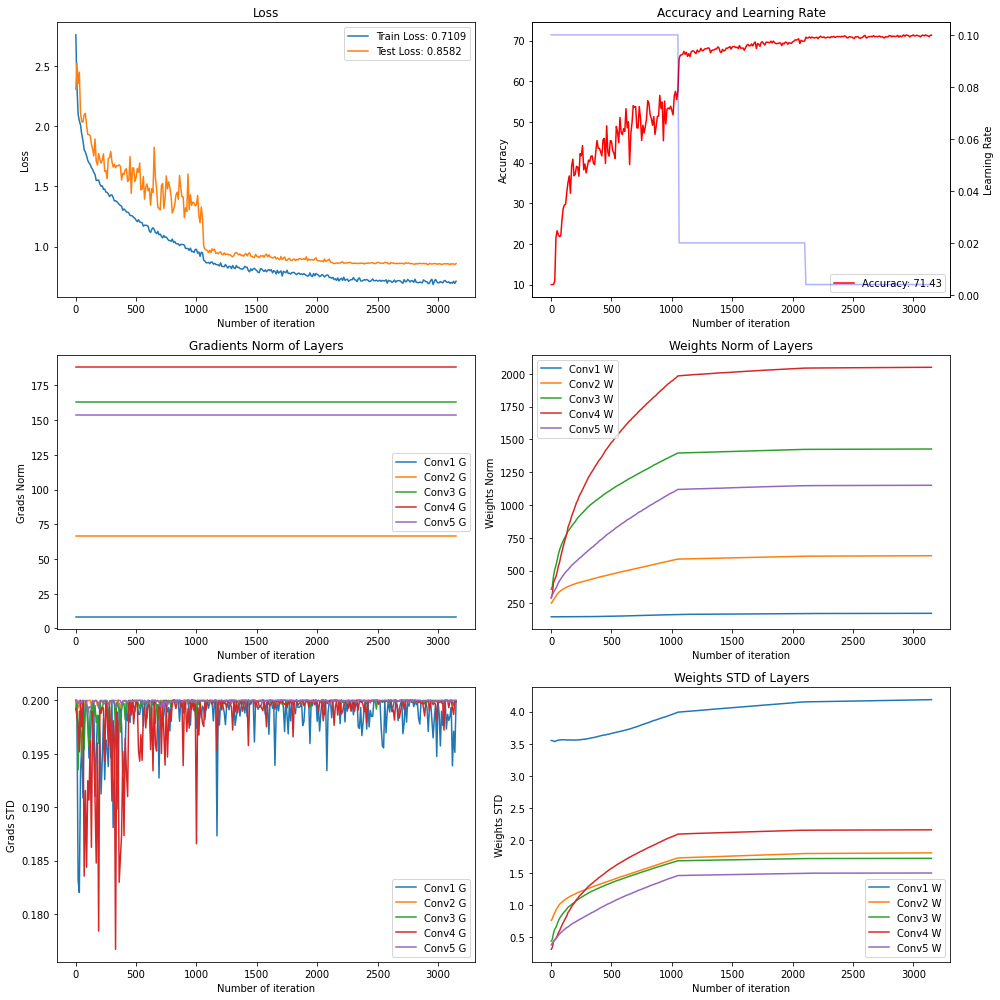

In [9]:
plot_train_test()

Weight 	epoch:0 	adder norm:619.864136	adder std:0.413203	adder max:6.083389	adder min:-6.085108
Weight 	epoch:0 	conv norm:128.093369 	conv std:0.027944 	conv max:0.076547 	conv  min:-0.076547
Weight 	epoch:1 	adder norm:921.368164	adder std:0.612685	adder max:8.376725	adder min:-8.040637
Weight 	epoch:1 	conv norm:128.087982 	conv std:0.027943 	conv max:0.087280 	conv  min:-0.120426
Weight 	epoch:21 	adder norm:2740.861572	adder std:1.814624	adder max:51.248062	adder min:-57.604828
Weight 	epoch:21 	conv norm:126.860367 	conv std:0.027675 	conv max:0.087154 	conv  min:-0.115792
Weight 	epoch:42 	adder norm:2815.434814	adder std:1.862610	adder max:53.551388	adder min:-56.397385
Weight 	epoch:42 	conv norm:126.597542 	conv std:0.027618 	conv max:0.092976 	conv  min:-0.114512
Weight 	epoch:63 	adder norm:2823.371582	adder std:1.867527	adder max:54.192921	adder min:-56.307686
Weight 	epoch:63 	conv norm:126.544556 	conv std:0.027606 	conv max:0.092919 	conv  min:-0.114416


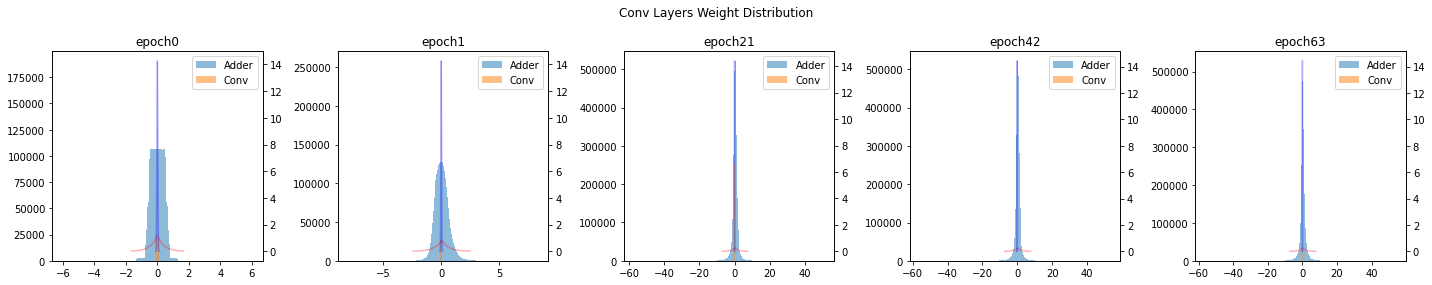

In [10]:
plot_hist(model)

In [14]:
class AlexNet_CN1BN(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(AlexNet_CN1BN, self).__init__()
        
        self.features = nn.Sequential(
            collections.OrderedDict(
                [
                    #("ln1", LayerNorm()),
                    #("conv1", Adder2D(3, 64, kernel_size=3, stride=2, padding=1, bias=BIAS)),
                    ("conv1", nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1, bias=BIAS)),
                    ("bn1", nn.BatchNorm2d(64)),
                    ("relu1", nn.ReLU(inplace=True)),
                    ("pool1", nn.MaxPool2d(kernel_size=2)),
                    #("ln2", LayerNorm()),
                    ("conv2", Adder2D(64, 192, kernel_size=3, padding=1, bias=BIAS)),
                    ("bn2", nn.BatchNorm2d(192)),
                    ("relu2", nn.ReLU(inplace=True)),
                    ("pool2", nn.MaxPool2d(kernel_size=2)),
                    #("ln3", LayerNorm()),
                    ("conv3", Adder2D(192, 384, kernel_size=3, padding=1, bias=BIAS)),
                    ("bn3", nn.BatchNorm2d(384)),
                    ("relu3", nn.ReLU(inplace=True)),
                    #("ln4", LayerNorm()),
                    ("conv4", Adder2D(384, 256, kernel_size=3, padding=1, bias=BIAS)),
                    ("bn4", nn.BatchNorm2d(256)),
                    ("relu4", nn.ReLU(inplace=True)),
                    #("ln5", LayerNorm()),
                    ("conv5", Adder2D(256, 256, kernel_size=3, padding=1, bias=BIAS)),
                    ("bn5", nn.BatchNorm2d(256)),
                    ("relu5", nn.ReLU(inplace=True)),
                    ("pool3", nn.MaxPool2d(kernel_size=2))
                ]
            )
        )
        self.classifier = nn.Sequential(
            collections.OrderedDict(
                [
                    ("fc1", nn.Conv2d(256 * 2 * 2, 4096, kernel_size=1, bias=BIAS)),
                    ("bn6", nn.BatchNorm2d(4096)),
                    ("relu6", nn.ReLU(inplace=True)),
                    ("fc2", nn.Conv2d(4096, 4096, kernel_size=1, bias=BIAS)),
                    ("bn7", nn.BatchNorm2d(4096)),
                    ("relu7", nn.ReLU(inplace=True)),
                    ("fc3", nn.Conv2d(4096, num_classes, kernel_size=1, bias=BIAS)),
                    ("relu8", nn.ReLU(inplace=True)),
                    ("bn8", nn.BatchNorm2d(num_classes))
                ]
            )
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.shape[0], -1)
        x = x.reshape((x.shape[0], x.shape[1], 1, 1)) # (batch, 256*2*2, 1, 1)
        x = self.classifier(x)
        return x.view(x.size(0), -1)
    
model = AlexNet_CN1BN()

#for name, param in model.named_parameters():
#    if param.requires_grad:
#        print(name, param.data.size())

In [15]:
run(model, 'SGD', 'Step', 'uniform')

SGD	Step
features.conv1.weight True torch.Size([64, 3, 3, 3])
features.bn1.weight True torch.Size([64])
features.bn1.bias True torch.Size([64])
features.conv2.adder True torch.Size([192, 64, 3, 3])
features.bn2.weight True torch.Size([192])
features.bn2.bias True torch.Size([192])
features.conv3.adder True torch.Size([384, 192, 3, 3])
features.bn3.weight True torch.Size([384])
features.bn3.bias True torch.Size([384])
features.conv4.adder True torch.Size([256, 384, 3, 3])
features.bn4.weight True torch.Size([256])
features.bn4.bias True torch.Size([256])
features.conv5.adder True torch.Size([256, 256, 3, 3])
features.bn5.weight True torch.Size([256])
features.bn5.bias True torch.Size([256])
classifier.fc1.weight True torch.Size([4096, 1024, 1, 1])
classifier.bn6.weight True torch.Size([4096])
classifier.bn6.bias True torch.Size([4096])
classifier.fc2.weight True torch.Size([4096, 4096, 1, 1])
classifier.bn7.weight True torch.Size([4096])
classifier.bn7.bias True torch.Size([4096])
class

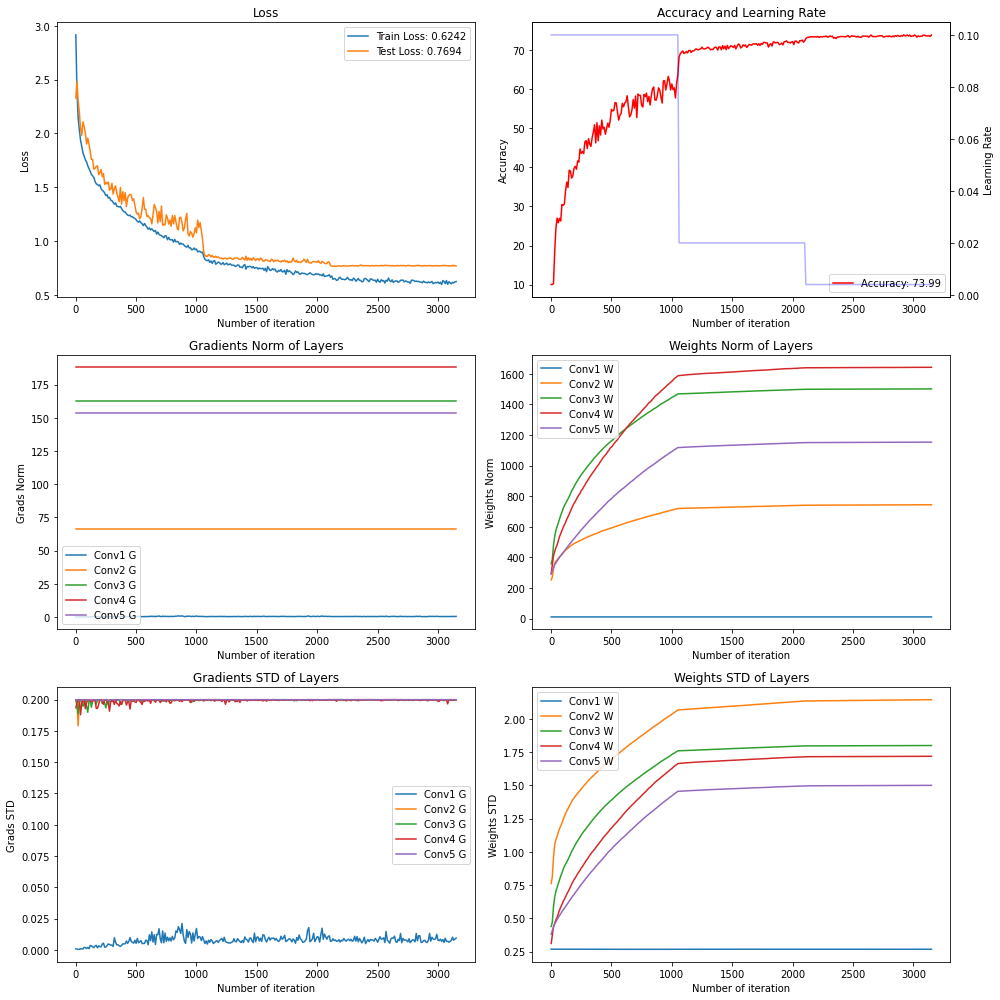

In [16]:
plot_train_test()

Weight 	epoch:0 	adder norm:602.293457	adder std:0.401645	adder max:1.317613	adder min:-1.317612
Weight 	epoch:0 	conv norm:128.546356 	conv std:0.028042 	conv max:0.470651 	conv  min:-0.470709
Weight 	epoch:1 	adder norm:939.885620	adder std:0.622507	adder max:11.002684	adder min:-8.204806
Weight 	epoch:1 	conv norm:128.493225 	conv std:0.028030 	conv max:0.472885 	conv  min:-0.473739
Weight 	epoch:21 	adder norm:2538.631836	adder std:1.671816	adder max:45.292938	adder min:-48.217369
Weight 	epoch:21 	conv norm:127.279526 	conv std:0.027765 	conv max:0.608893 	conv  min:-0.576541
Weight 	epoch:42 	adder norm:2609.487061	adder std:1.716607	adder max:45.268654	adder min:-47.722816
Weight 	epoch:42 	conv norm:127.019203 	conv std:0.027708 	conv max:0.623550 	conv  min:-0.584002
Weight 	epoch:63 	adder norm:2615.096191	adder std:1.719980	adder max:45.305622	adder min:-48.146027
Weight 	epoch:63 	conv norm:126.966370 	conv std:0.027697 	conv max:0.625610 	conv  min:-0.584932


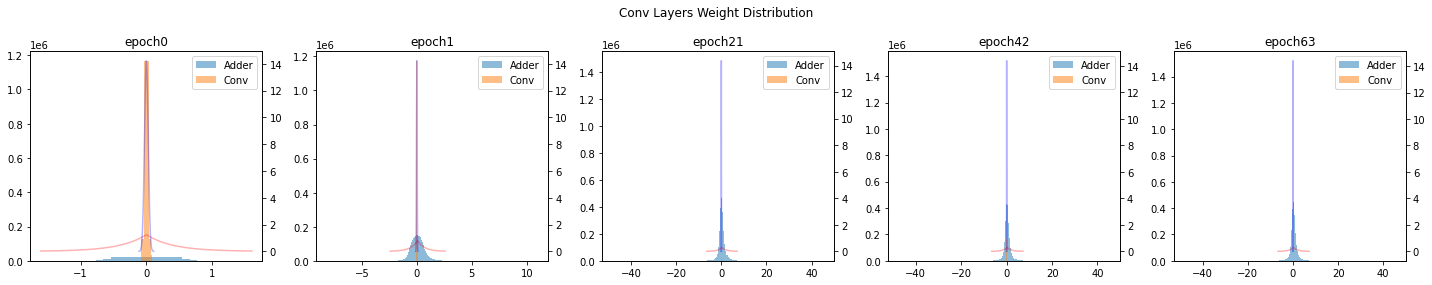

In [17]:
plot_hist(model)